In [1]:
#!/usr/bin/env jupyter
"""
Visualization notebook for temporal task performance experiment.
Shows input/output patterns, network activity, and readout performance.
"""

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import sys
import os
from sklearn.model_selection import StratifiedKFold

# Add project to path
sys.path.insert(0, os.path.abspath('..'))

from experiments.task_performance_experiment import TaskPerformanceExperiment
from experiments.experiment_utils import (
    apply_exponential_filter,
    train_task_readout,
    predict_task_readout,
    evaluate_temporal_task
)
from analysis.common_utils import spikes_to_matrix

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("=" * 80)
print("TEMPORAL TASK VISUALIZATION")
print("=" * 80)

TEMPORAL TASK VISUALIZATION


In [2]:
# ============================================================================
# PART 1: CREATE EXPERIMENT AND GENERATE PATTERNS
# ============================================================================

print("\n[1] Creating experiment and generating patterns...\n")

# Small experiment for visualization
exp = TaskPerformanceExperiment(
    task_type='temporal',
    n_neurons=1000,           # Small for speed
    n_input_patterns=4,      # 4 patterns
    input_dim_intrinsic=5,   # Input HD dim
    input_dim_embedding=5,   # Input embedding
    output_dim_intrinsic=2,  # Output HD dim
    output_dim_embedding=3,  # Output embedding
    n_trials_per_pattern=100, # 20 trials per pattern (80 total)
    stimulus_duration=200.0, # Short for speed
    tau_syn=5.0,
    static_input_mode="common_tonic",
    hd_input_mode="common_tonic",
    signal_cache_dir='temp_viz_cache'
)

session_id = 42
v_th_std = .0
g_std = 1.
static_input_rate = 30.0

# Generate input patterns
print("Generating INPUT patterns...")
input_patterns = {}
for pattern_id in range(exp.n_input_patterns):
    exp.input_generator.initialize_base_input(
        session_id=session_id,
        hd_dim=exp.input_dim_intrinsic,
        pattern_id=pattern_id,
        rate_rnn_params={'n_neurons': 1000, 'T': 400.0, 'g': 2.0}
    )
    input_patterns[pattern_id] = exp.input_generator.Y_base.copy()
    print(f"  Pattern {pattern_id}: shape {input_patterns[pattern_id].shape}")

# Generate output patterns
print("\nGenerating OUTPUT patterns...")
output_patterns = exp.generate_output_patterns(session_id)
for pattern_id, pattern in output_patterns.items():
    print(f"  Pattern {pattern_id}: shape {pattern.shape}")

print(f"\n✓ Generated {len(input_patterns)} input patterns and {len(output_patterns)} output patterns")


[1] Creating experiment and generating patterns...

Generating INPUT patterns...
  Pattern 0: shape (2000, 5)
  Pattern 1: shape (2000, 5)
  Pattern 2: shape (2000, 5)
  Pattern 3: shape (2000, 5)

Generating OUTPUT patterns...
  Pattern 0: shape (2000, 3)
  Pattern 1: shape (2000, 3)
  Pattern 2: shape (2000, 3)
  Pattern 3: shape (2000, 3)

✓ Generated 4 input patterns and 4 output patterns



[2] Visualizing patterns...



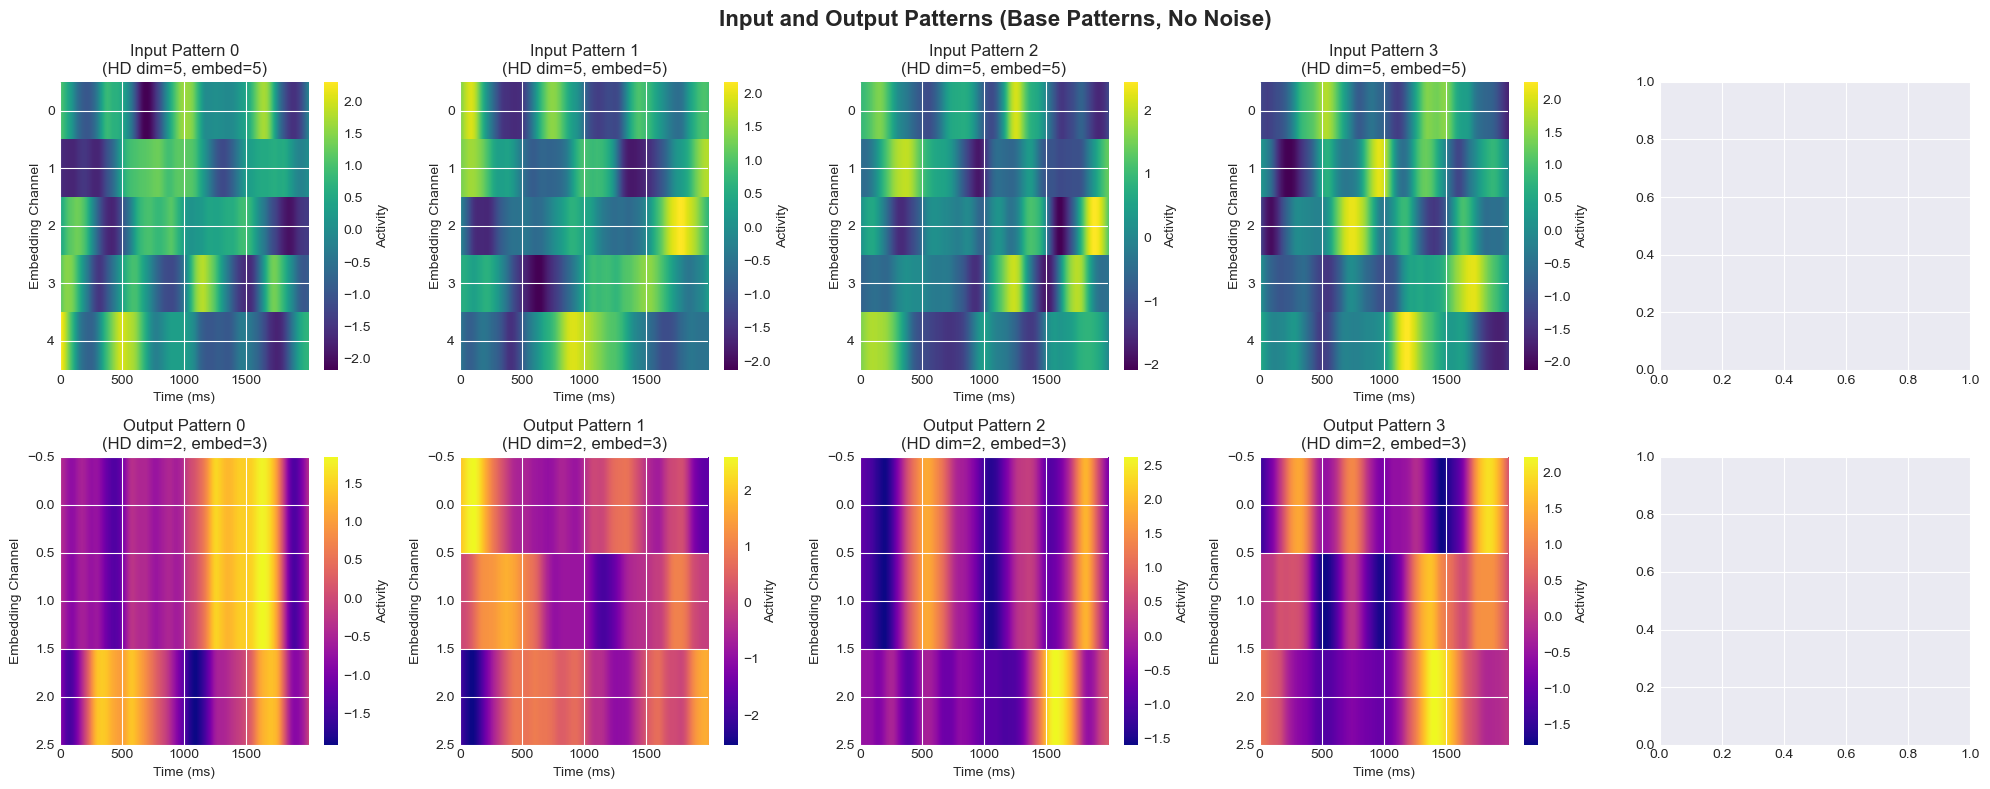


Input pattern correlations:


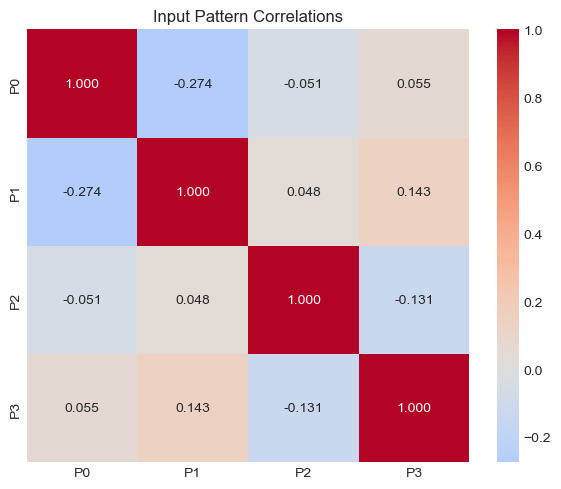


Output pattern correlations:


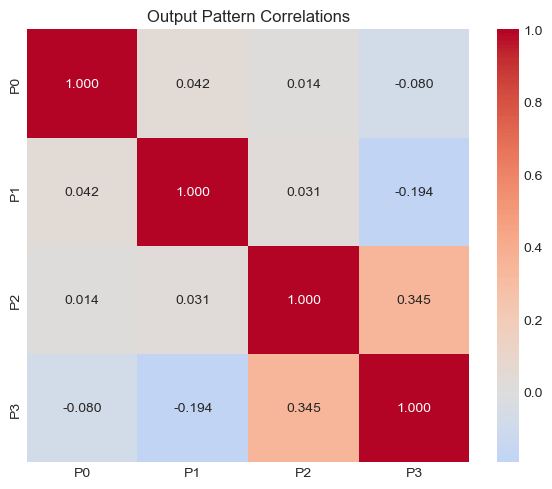

In [3]:
# ============================================================================
# PART 2: VISUALIZE INPUT AND OUTPUT PATTERNS
# ============================================================================

print("\n[2] Visualizing patterns...\n")

fig, axes = plt.subplots(2, 5, figsize=(20, 8))
fig.suptitle('Input and Output Patterns (Base Patterns, No Noise)', fontsize=16, fontweight='bold')

for pattern_id in range(exp.n_input_patterns):
    # Input pattern
    ax_in = axes[0, pattern_id]
    im = ax_in.imshow(input_patterns[pattern_id].T, aspect='auto', cmap='viridis', interpolation='nearest')
    ax_in.set_title(f'Input Pattern {pattern_id}\n(HD dim={exp.input_dim_intrinsic}, embed={exp.input_dim_embedding})')
    ax_in.set_xlabel('Time (ms)')
    ax_in.set_ylabel('Embedding Channel')
    plt.colorbar(im, ax=ax_in, label='Activity')
    
    # Output pattern
    ax_out = axes[1, pattern_id]
    im = ax_out.imshow(output_patterns[pattern_id].T, aspect='auto', cmap='plasma', interpolation='nearest')
    ax_out.set_title(f'Output Pattern {pattern_id}\n(HD dim={exp.output_dim_intrinsic}, embed={exp.output_dim_embedding})')
    ax_out.set_xlabel('Time (ms)')
    ax_out.set_ylabel('Embedding Channel')
    plt.colorbar(im, ax=ax_out, label='Activity')

plt.tight_layout()
plt.show()

# Show correlation between patterns
print("\nInput pattern correlations:")
n_patterns = len(input_patterns)
corr_matrix = np.zeros((n_patterns, n_patterns))
for i in range(n_patterns):
    for j in range(n_patterns):
        flat_i = input_patterns[i].flatten()
        flat_j = input_patterns[j].flatten()
        corr_matrix[i, j] = np.corrcoef(flat_i, flat_j)[0, 1]

plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm', center=0,
            xticklabels=[f'P{i}' for i in range(n_patterns)],
            yticklabels=[f'P{i}' for i in range(n_patterns)])
plt.title('Input Pattern Correlations')
plt.tight_layout()
plt.show()

print("\nOutput pattern correlations:")
corr_matrix_out = np.zeros((n_patterns, n_patterns))
for i in range(n_patterns):
    for j in range(n_patterns):
        flat_i = output_patterns[i].flatten()
        flat_j = output_patterns[j].flatten()
        corr_matrix_out[i, j] = np.corrcoef(flat_i, flat_j)[0, 1]

plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix_out, annot=True, fmt='.3f', cmap='coolwarm', center=0,
            xticklabels=[f'P{i}' for i in range(n_patterns)],
            yticklabels=[f'P{i}' for i in range(n_patterns)])
plt.title('Output Pattern Correlations')
plt.tight_layout()
plt.show()

In [4]:
# ============================================================================
# PART 3: SIMULATE TRIALS
# ============================================================================

print("\n[3] Simulating trials...\n")

all_trial_results = []
n_total_trials = exp.n_input_patterns * exp.n_trials_per_pattern

print(f"Simulating {n_total_trials} trials...")

for pattern_id in range(exp.n_input_patterns):
    print(f"  Pattern {pattern_id}: ", end='')
    for trial_idx in range(exp.n_trials_per_pattern):
        trial_id = pattern_id * exp.n_trials_per_pattern + trial_idx
        
        # Generate noisy input
        from src.rng_utils import get_rng
        rng = get_rng(session_id, v_th_std, g_std, trial_id,
                     f'hd_input_noise_{pattern_id}',
                     rate=static_input_rate,
                     hd_dim=exp.input_dim_intrinsic,
                     embed_dim=exp.input_dim_embedding)
        
        noise = rng.normal(0, 0.5, input_patterns[pattern_id].shape)
        noisy_input = input_patterns[pattern_id] + noise
        noisy_input = noisy_input - np.min(noisy_input)
        noisy_input = noisy_input * 1.0
        
        # Run trial
        trial_result = exp.run_single_trial(
            session_id=session_id,
            v_th_std=v_th_std,
            g_std=g_std,
            trial_id=trial_id,
            pattern_id=pattern_id,
            noisy_input_pattern=noisy_input,
            static_input_rate=static_input_rate,
            v_th_distribution='normal'
        )
        
        # Add global trial index (needed by convert_spikes_to_traces)
        trial_result['global_trial_idx'] = trial_id
        
        all_trial_results.append(trial_result)
        
        if (trial_idx + 1) % 5 == 0:
            print(f"{trial_idx + 1}", end=' ')
    print("✓")

print(f"\n✓ Simulated {len(all_trial_results)} trials")


[3] Simulating trials...

Simulating 400 trials...
  Pattern 0: 5 10 15 20 25 30 35 40 45 50 55 60 65 70 75 80 85 90 95 100 ✓
  Pattern 1: 5 10 15 20 25 30 35 40 45 50 55 60 65 70 75 80 85 90 95 100 ✓
  Pattern 2: 5 10 15 20 25 30 35 40 45 50 55 60 65 70 75 80 85 90 95 100 ✓
  Pattern 3: 5 10 15 20 25 30 35 40 45 50 55 60 65 70 75 80 85 90 95 100 ✓

✓ Simulated 400 trials


In [5]:
output_patterns.keys()

dict_keys([0, 1, 2, 3])

In [6]:
output_patterns[3].shape

(2000, 3)

In [7]:
for i in [0,1,2,3]:
    output_patterns[i] = np.zeros((2000,4),dtype=float)
    output_patterns[i][:,i] = 1


[4] Converting spikes to traces...

Traces shape: (400, 2000, 1000)
Ground truth shape: (400, 2000, 4)
Pattern IDs shape: (400,)


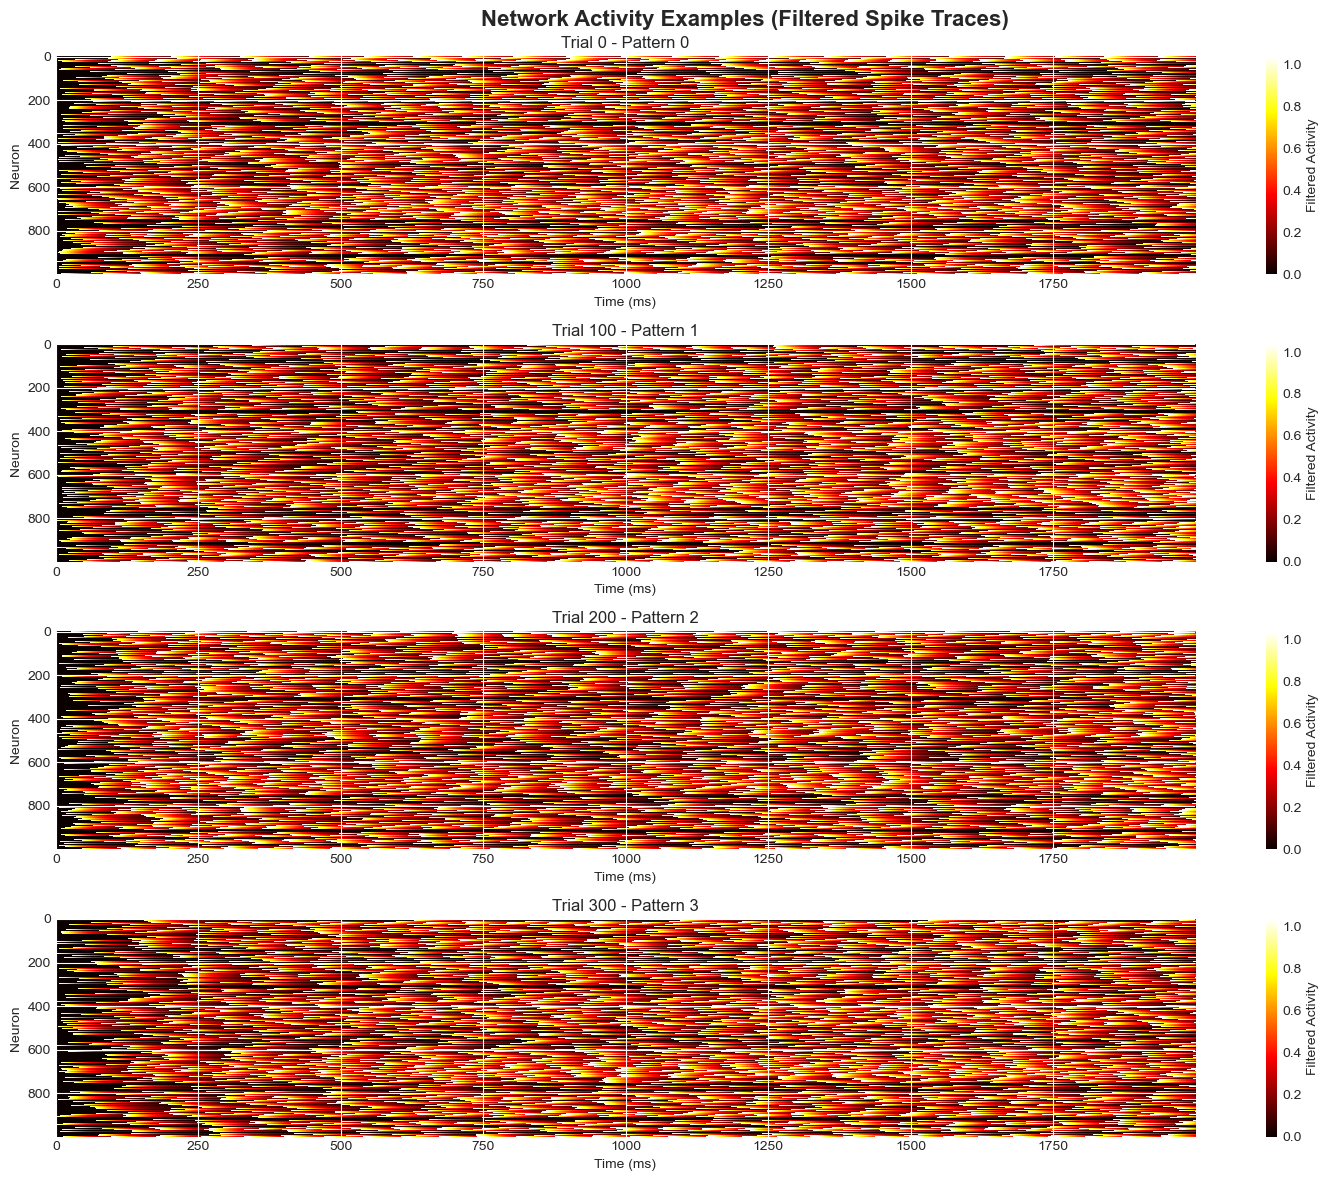

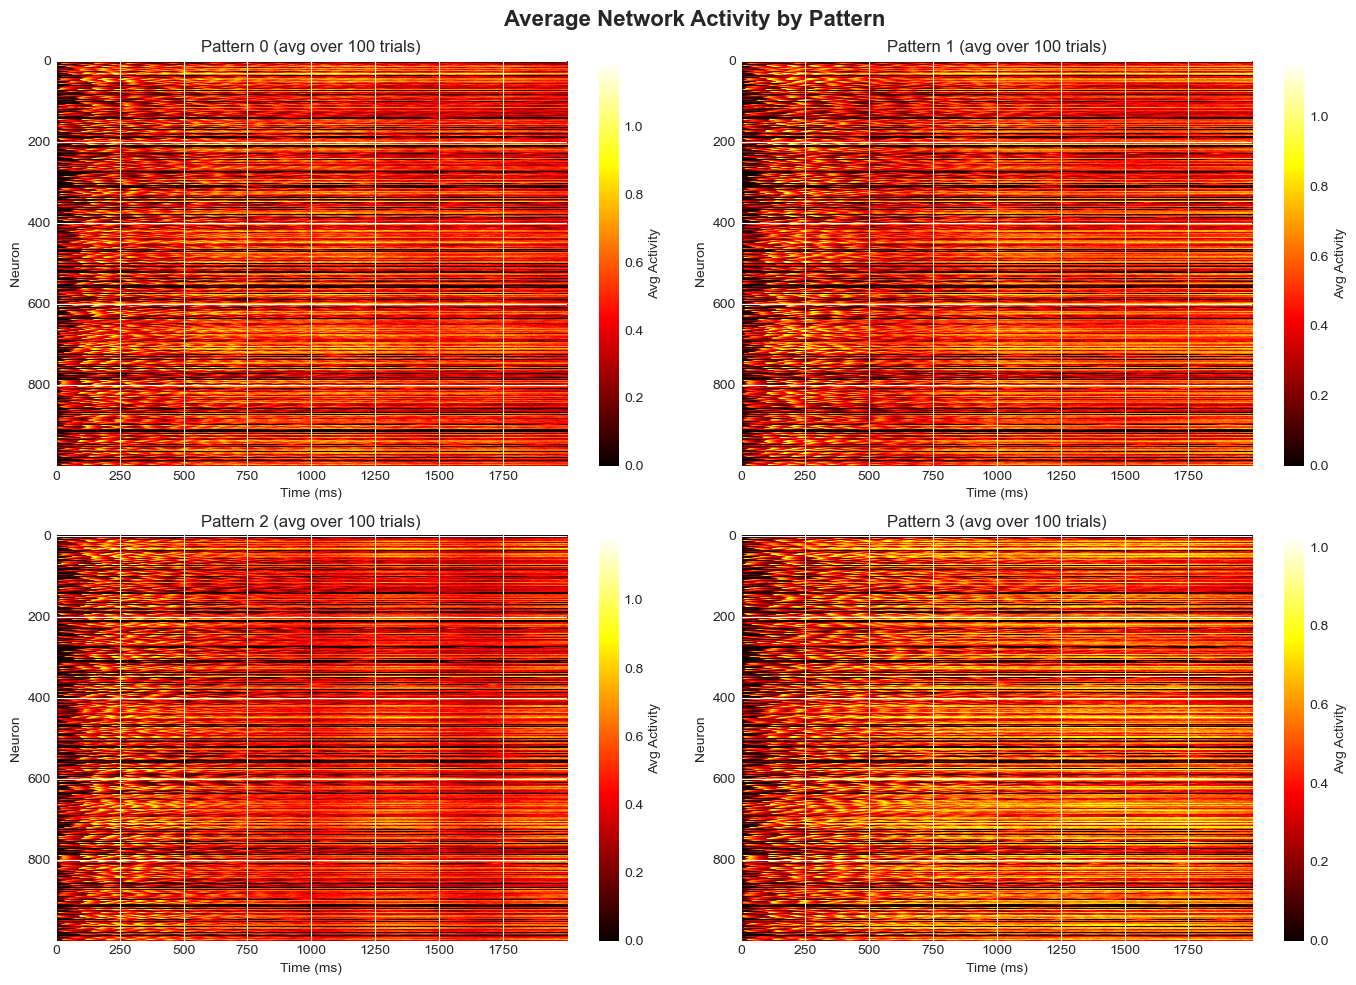

In [8]:
# ============================================================================
# PART 4: CONVERT TO TRACES AND VISUALIZE NETWORK ACTIVITY
# ============================================================================

print("\n[4] Converting spikes to traces...\n")

# output_patterns = input_patterns  # ← Use this line to reconstruct inputs!

traces_all, ground_truth_all, pattern_ids = exp.convert_spikes_to_traces(
    all_trial_results,
    output_patterns,
    exp.n_input_patterns,
    exp.n_trials_per_pattern
)

print(f"Traces shape: {traces_all.shape}")
print(f"Ground truth shape: {ground_truth_all.shape}")
print(f"Pattern IDs shape: {pattern_ids.shape}")

# Visualize network activity for a few example trials
fig, axes = plt.subplots(4, 1, figsize=(15, 12))
fig.suptitle('Network Activity Examples (Filtered Spike Traces)', fontsize=16, fontweight='bold')

for i in range(4):
    trial_idx = i * 100  # One trial per pattern
    pattern_id = pattern_ids[trial_idx]
    
    ax = axes[i]
    im = ax.imshow(traces_all[trial_idx].T, aspect='auto', cmap='hot', interpolation='nearest', vmax=np.percentile(traces_all, 95))
    ax.set_title(f'Trial {trial_idx} - Pattern {pattern_id}')
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Neuron')
    plt.colorbar(im, ax=ax, label='Filtered Activity')

plt.tight_layout()
plt.show()

# Show average activity per pattern
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()
fig.suptitle('Average Network Activity by Pattern', fontsize=16, fontweight='bold')

for pattern_id in range(exp.n_input_patterns):
    mask = pattern_ids == pattern_id
    avg_traces = traces_all[mask].mean(axis=0)
    
    ax = axes[pattern_id]
    im = ax.imshow(avg_traces.T, aspect='auto', cmap='hot', interpolation='nearest')
    ax.set_title(f'Pattern {pattern_id} (avg over {mask.sum()} trials)')
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Neuron')
    plt.colorbar(im, ax=ax, label='Avg Activity')

plt.tight_layout()
plt.show()

In [9]:
# ============================================================================
# PART 5: CROSS-VALIDATION TRAINING
# ============================================================================

print("\n[5] Training readout with cross-validation...\n")

n_folds = 20
print(f"Using {n_folds}-fold stratified CV")

# Get RNG for CV splits
from src.rng_utils import get_rng
rng_cv = get_rng(session_id, 0.0, 0.0, 0,
                f'task_{exp.task_type}_cv_splits',
                hd_dim=exp.input_dim_intrinsic,
                embed_dim=exp.input_dim_embedding)

cv_seed = int(rng_cv.integers(0, 2**31 - 1))

# Create stratified folds
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=cv_seed)
fold_splits = list(skf.split(traces_all, pattern_ids))

# Store results
fold_results = []
all_weights = []

print("\nTraining folds:")
for fold_idx, (train_idx, test_idx) in enumerate(fold_splits):
    print(f"  Fold {fold_idx}: ", end='')
    
    # Split data
    X_train = traces_all[train_idx]
    X_test = traces_all[test_idx]
    y_train = ground_truth_all[train_idx]
    y_test = ground_truth_all[test_idx]
    
    # Check stratification
    train_dist = np.bincount(pattern_ids[train_idx])
    test_dist = np.bincount(pattern_ids[test_idx])
    print(f"Train={train_dist.tolist()}, Test={test_dist.tolist()} ", end='')
    
    # Train readout
    W_readout = train_task_readout(X_train, y_train, exp.lambda_reg)
    all_weights.append(W_readout.copy())
    
    # Predict
    y_pred_train = predict_task_readout(X_train, W_readout)
    y_pred_test = predict_task_readout(X_test, W_readout)
    
    # Evaluate
    train_metrics = evaluate_temporal_task(y_pred_train, y_train)
    test_metrics = evaluate_temporal_task(y_pred_test, y_test)
    
    fold_results.append({
        'fold': fold_idx,
        'train_rmse': train_metrics['rmse_mean'],
        'train_r2': train_metrics['r2_mean'],
        'train_correlation': train_metrics['correlation_mean'],
        'test_rmse': test_metrics['rmse_mean'],
        'test_r2': test_metrics['r2_mean'],
        'test_correlation': test_metrics['correlation_mean'],
        'train_idx': train_idx,
        'test_idx': test_idx,
        'y_pred_test': y_pred_test,
        'y_test': y_test
    })
    
    print(f"RMSE={test_metrics['rmse_mean']:.4f}, R²={test_metrics['r2_mean']:.4f} ✓")

print("\n✓ Training completed")


[5] Training readout with cross-validation...

Using 20-fold stratified CV

Training folds:
  Fold 0: Train=[95, 95, 95, 95], Test=[5, 5, 5, 5] RMSE=0.4298, R²=0.0150 ✓
  Fold 1: Train=[95, 95, 95, 95], Test=[5, 5, 5, 5] RMSE=0.4320, R²=0.0047 ✓
  Fold 2: Train=[95, 95, 95, 95], Test=[5, 5, 5, 5] RMSE=0.4320, R²=0.0047 ✓
  Fold 3: Train=[95, 95, 95, 95], Test=[5, 5, 5, 5] RMSE=0.4298, R²=0.0148 ✓
  Fold 4: Train=[95, 95, 95, 95], Test=[5, 5, 5, 5] RMSE=0.4321, R²=0.0043 ✓
  Fold 5: Train=[95, 95, 95, 95], Test=[5, 5, 5, 5] RMSE=0.4292, R²=0.0176 ✓
  Fold 6: Train=[95, 95, 95, 95], Test=[5, 5, 5, 5] RMSE=0.4308, R²=0.0101 ✓
  Fold 7: Train=[95, 95, 95, 95], Test=[5, 5, 5, 5] RMSE=0.4307, R²=0.0105 ✓
  Fold 8: Train=[95, 95, 95, 95], Test=[5, 5, 5, 5] RMSE=0.4318, R²=0.0058 ✓
  Fold 9: Train=[95, 95, 95, 95], Test=[5, 5, 5, 5] 

KeyboardInterrupt: 


[6] Visualizing performance...

Train RMSE: 0.4290 ± 0.0001
Test RMSE:  0.4309 ± 0.0011
Train R²:   0.0184 ± 0.0003
Test R²:    0.0097 ± 0.0049
Train Corr: 0.1358 ± 0.0010
Test Corr:  0.1085 ± 0.0155


ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (20,) and arg 1 with shape (9,).

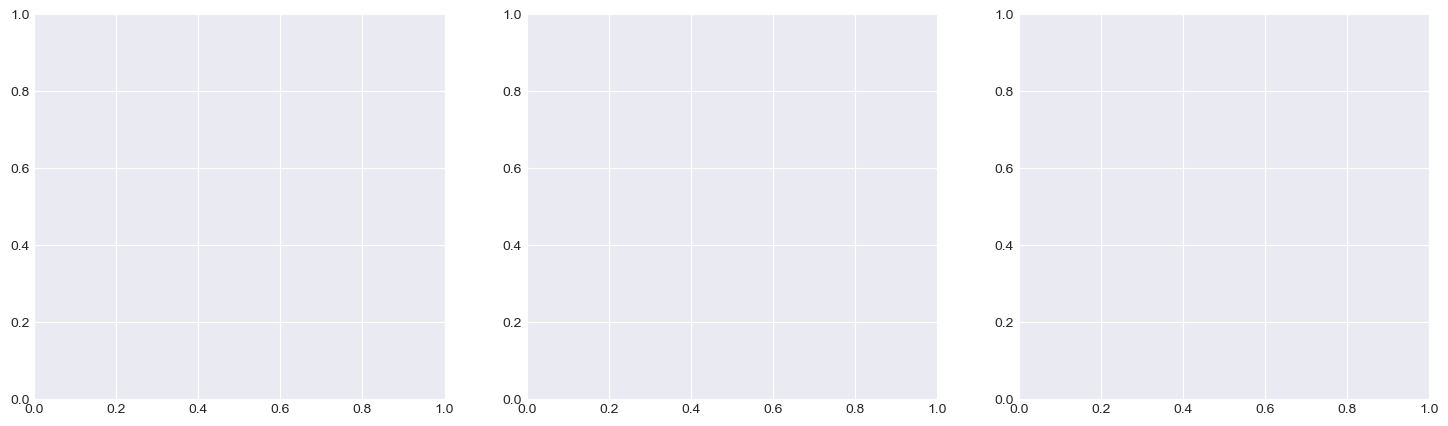

In [10]:
# ============================================================================
# PART 6: VISUALIZE PERFORMANCE METRICS
# ============================================================================

print("\n[6] Visualizing performance...\n")

# Aggregate metrics
train_rmse = [f['train_rmse'] for f in fold_results]
test_rmse = [f['test_rmse'] for f in fold_results]
train_r2 = [f['train_r2'] for f in fold_results]
test_r2 = [f['test_r2'] for f in fold_results]
train_corr = [f['train_correlation'] for f in fold_results]
test_corr = [f['test_correlation'] for f in fold_results]

print(f"Train RMSE: {np.mean(train_rmse):.4f} ± {np.std(train_rmse):.4f}")
print(f"Test RMSE:  {np.mean(test_rmse):.4f} ± {np.std(test_rmse):.4f}")
print(f"Train R²:   {np.mean(train_r2):.4f} ± {np.std(train_r2):.4f}")
print(f"Test R²:    {np.mean(test_r2):.4f} ± {np.std(test_r2):.4f}")
print(f"Train Corr: {np.mean(train_corr):.4f} ± {np.std(train_corr):.4f}")
print(f"Test Corr:  {np.mean(test_corr):.4f} ± {np.std(test_corr):.4f}")

# Plot performance across folds
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

metrics = [
    ('RMSE', train_rmse, test_rmse, 'lower is better'),
    ('R² Score', train_r2, test_r2, 'higher is better'),
    ('Correlation', train_corr, test_corr, 'higher is better')
]

for ax, (name, train_vals, test_vals, note) in zip(axes, metrics):
    x = np.arange(n_folds)
    width = 0.35
    
    ax.bar(x - width/2, train_vals, width, label='Train', alpha=0.8)
    ax.bar(x + width/2, test_vals, width, label='Test', alpha=0.8)
    
    ax.set_xlabel('Fold')
    ax.set_ylabel(name)
    ax.set_title(f'{name} across CV folds\n({note})')
    ax.set_xticks(x)
    ax.legend()
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


[7] Visualizing predictions (train and test)...

Train set size: 95 trials
Test set size: 5 trials

Fold 0 Performance:
  Train RMSE: 0.7898, R²: 0.3723, Corr: 0.6037
  Test RMSE:  0.8026, R²: 0.3520, Corr: 0.5869


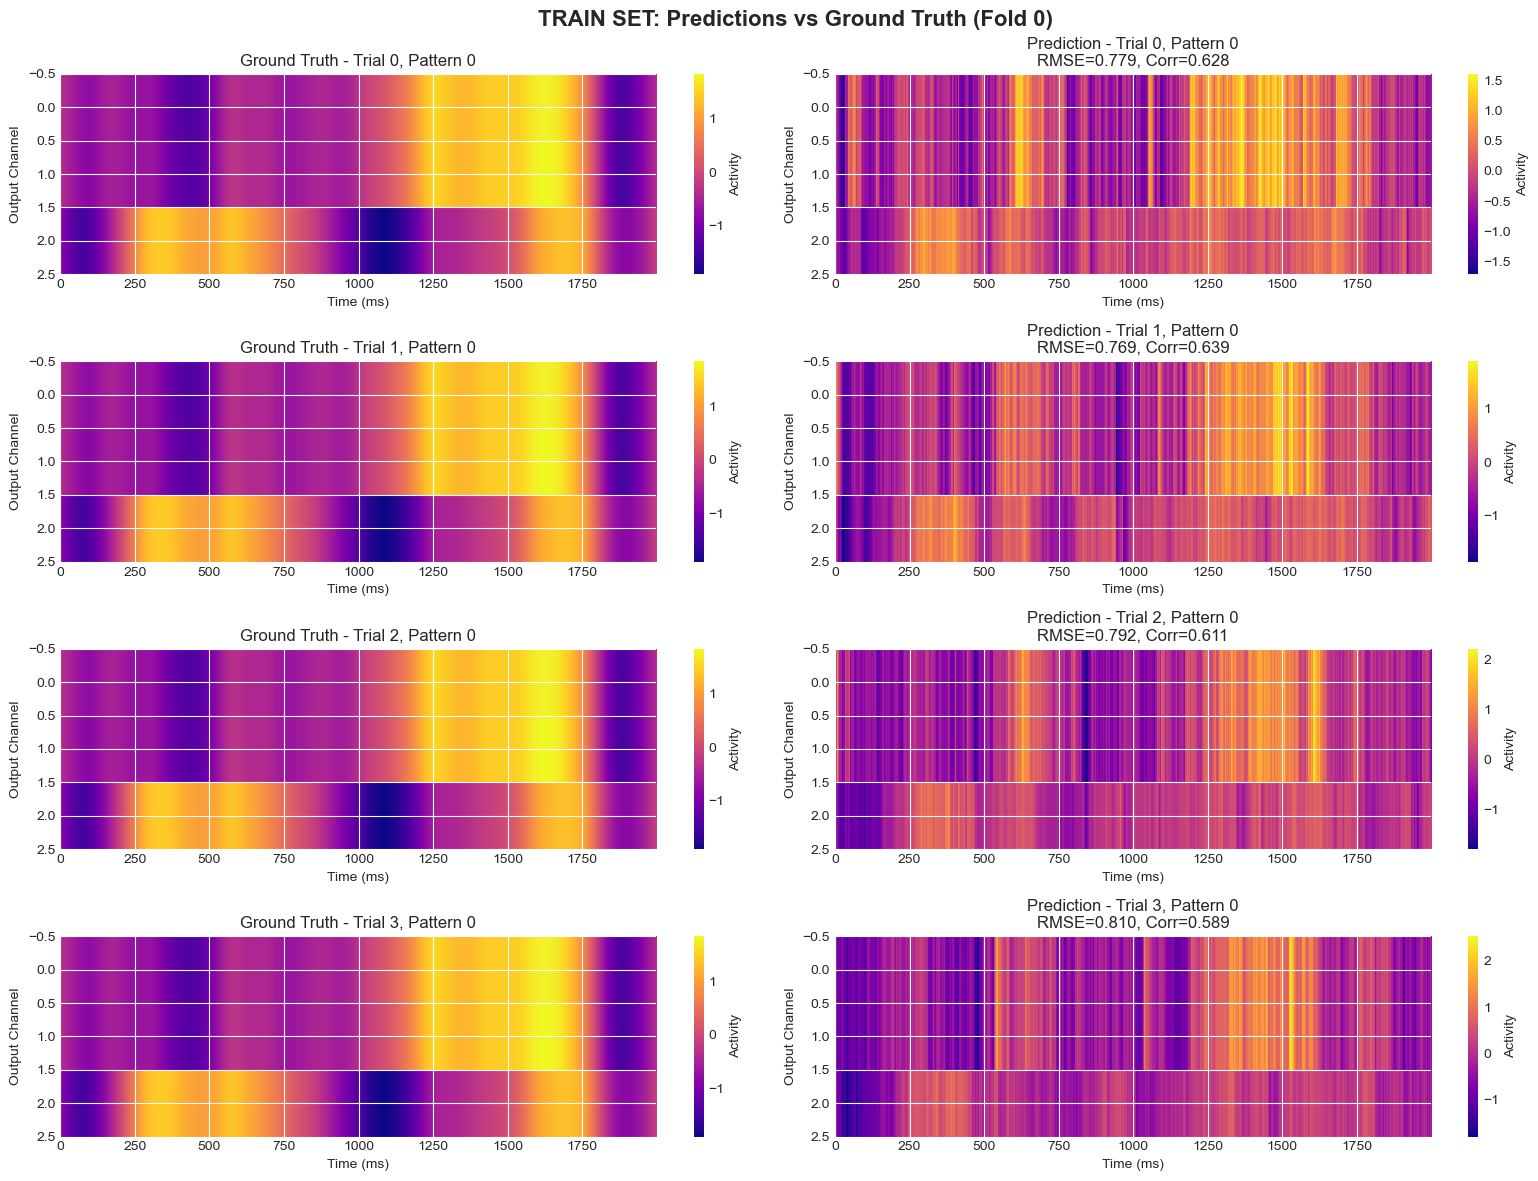

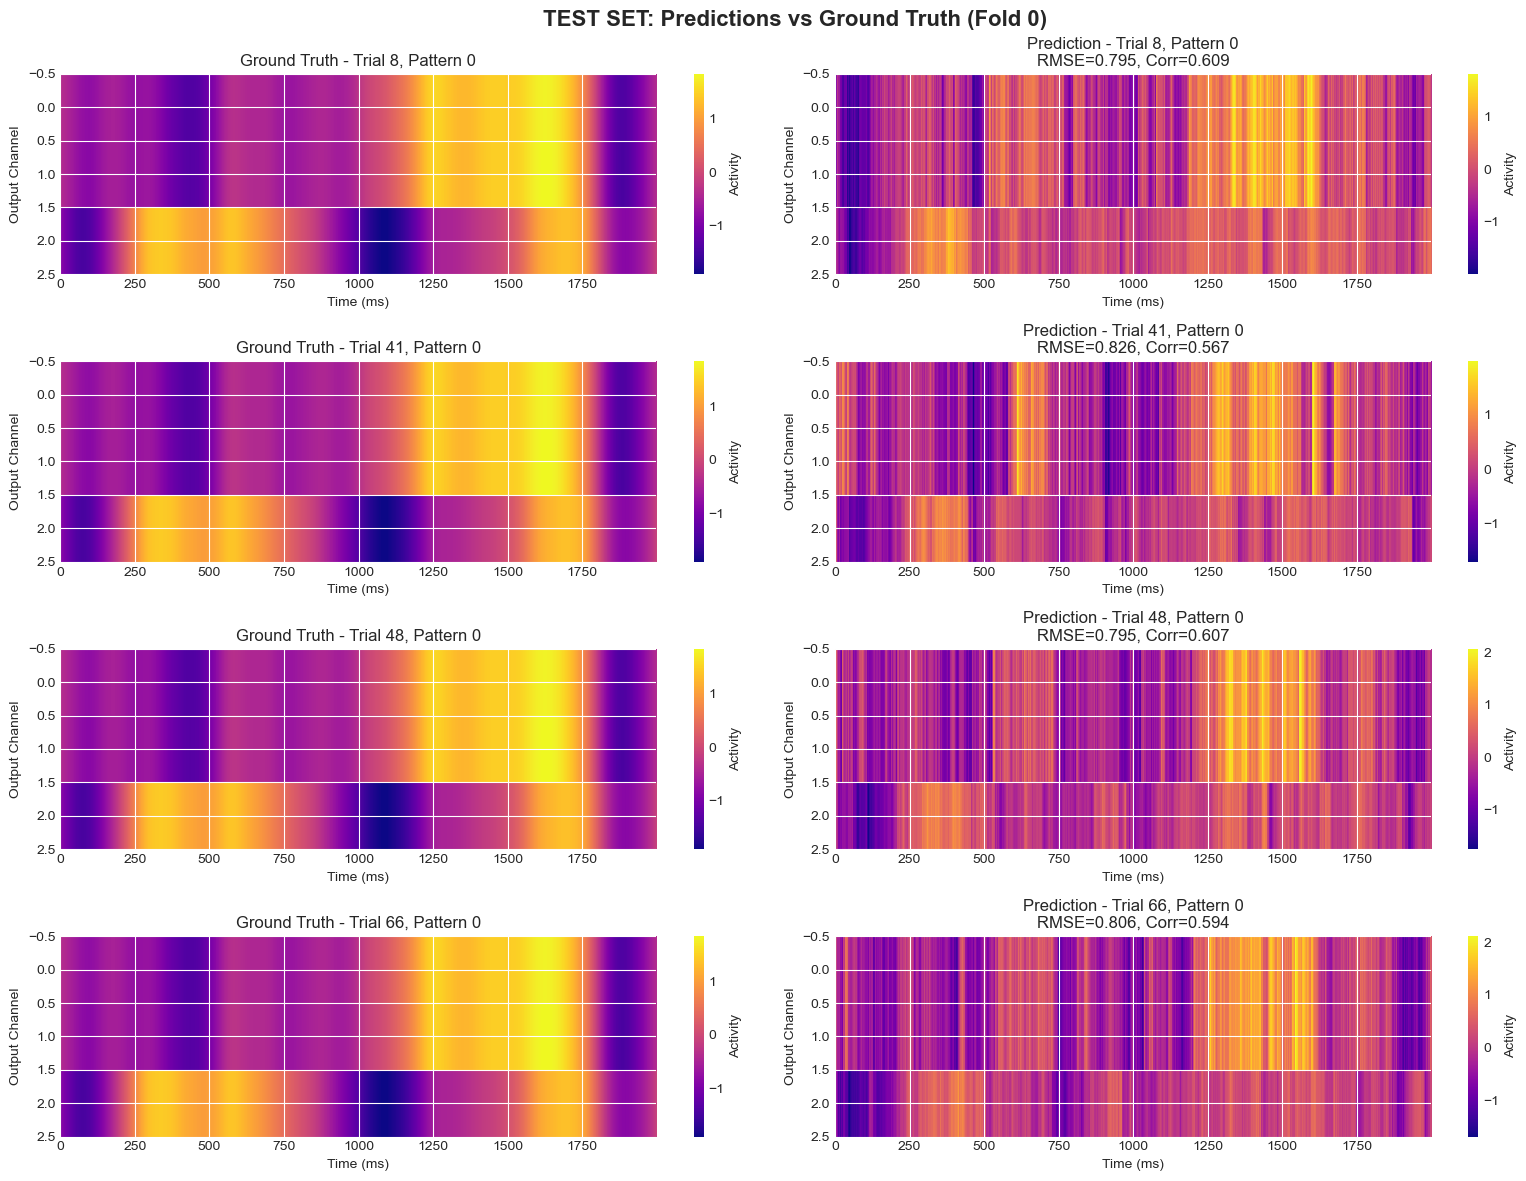

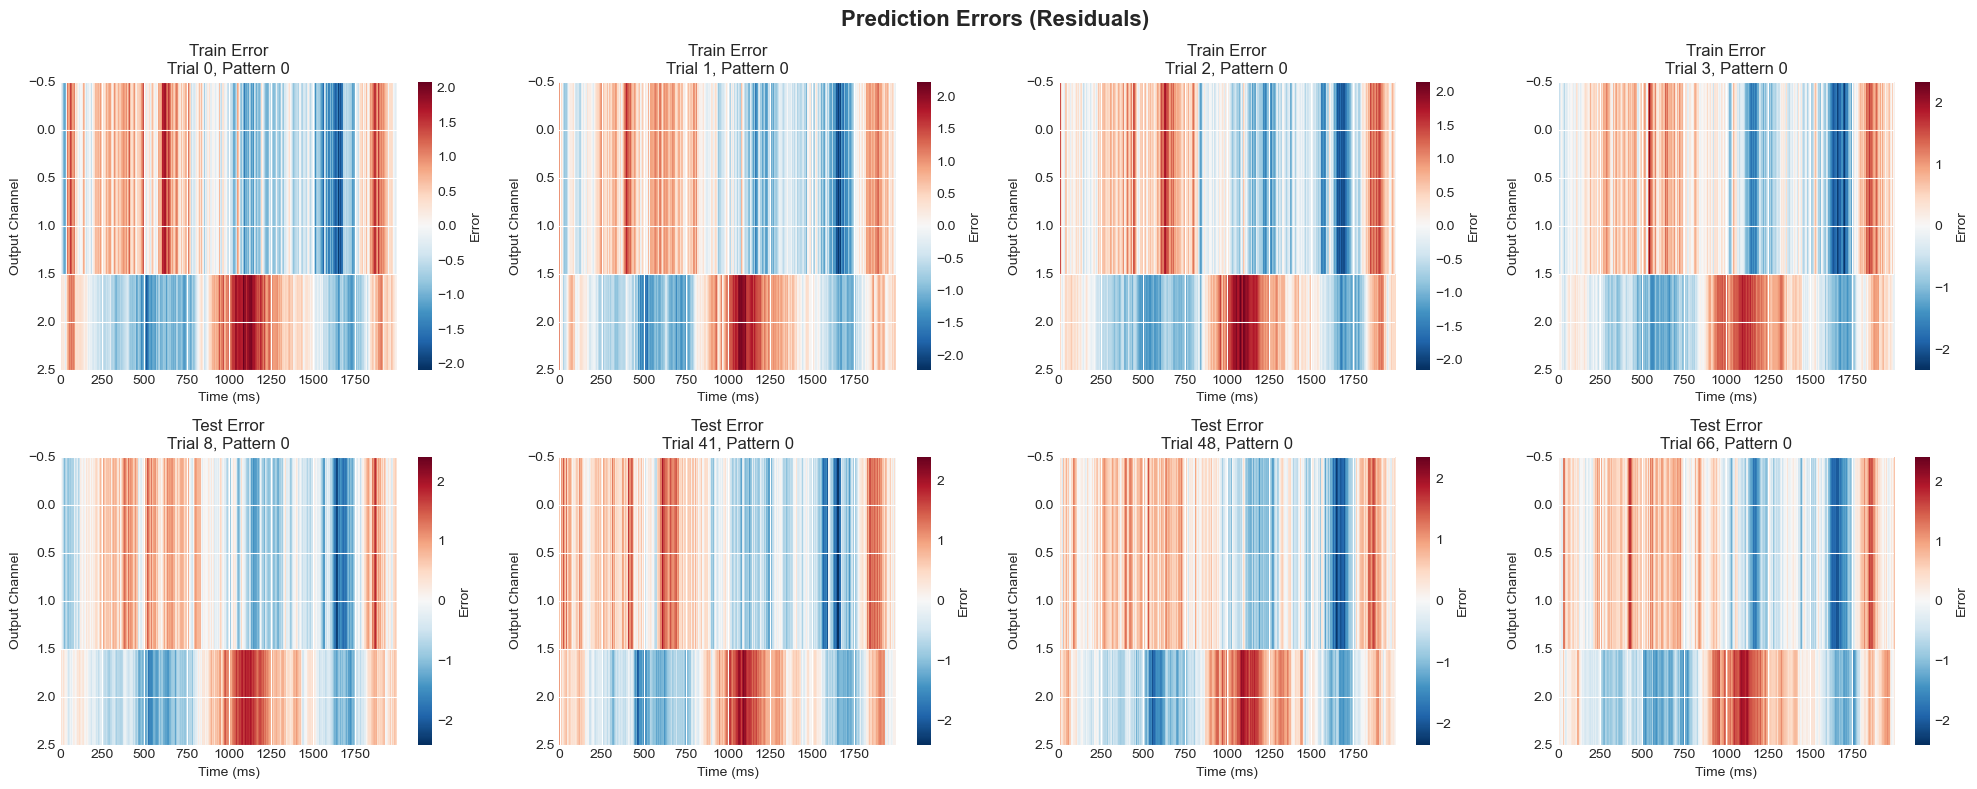

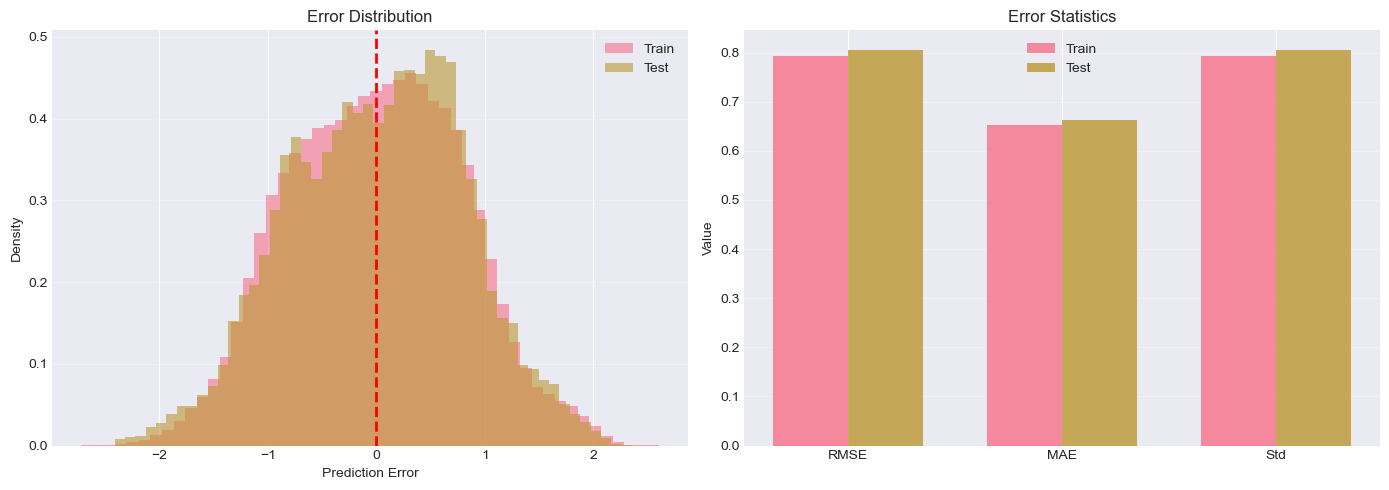


Error Analysis:
  Train RMSE: 0.7923, MAE: 0.6522, Std: 0.7923
  Test RMSE:  0.8050, MAE: 0.6622, Std: 0.8049
  Overfitting ratio (Test/Train RMSE): 1.016


In [9]:
# ============================================================================
# PART 7: VISUALIZE PREDICTIONS VS GROUND TRUTH (TRAIN AND TEST)
# ============================================================================

print("\n[7] Visualizing predictions (train and test)...\n")

# Use fold 0 for visualization
fold_0 = fold_results[0]
train_idx = fold_0['train_idx']
test_idx = fold_0['test_idx']

# Get predictions for train set
X_train_fold0 = traces_all[train_idx]
y_train_fold0 = ground_truth_all[train_idx]
W_fold0 = all_weights[0]
y_pred_train = predict_task_readout(X_train_fold0, W_fold0)

# Get test predictions
y_pred_test = fold_0['y_pred_test']
y_test = fold_0['y_test']

print(f"Train set size: {len(train_idx)} trials")
print(f"Test set size: {len(test_idx)} trials")

# Calculate metrics
train_metrics = evaluate_temporal_task(y_pred_train, y_train_fold0)
test_metrics = evaluate_temporal_task(y_pred_test, y_test)

print(f"\nFold 0 Performance:")
print(f"  Train RMSE: {train_metrics['rmse_mean']:.4f}, R²: {train_metrics['r2_mean']:.4f}, Corr: {train_metrics['correlation_mean']:.4f}")
print(f"  Test RMSE:  {test_metrics['rmse_mean']:.4f}, R²: {test_metrics['r2_mean']:.4f}, Corr: {test_metrics['correlation_mean']:.4f}")

# ============================================================================
# Show TRAIN predictions for first 4 train trials
# ============================================================================

fig, axes = plt.subplots(4, 2, figsize=(16, 12))
fig.suptitle('TRAIN SET: Predictions vs Ground Truth (Fold 0)', fontsize=16, fontweight='bold')

for i in range(min(4, len(train_idx))):
    trial_idx = train_idx[i]
    pattern_id = pattern_ids[trial_idx]
    
    # Ground truth
    ax_true = axes[i, 0]
    im = ax_true.imshow(y_train_fold0[i].T, aspect='auto', cmap='plasma', interpolation='nearest')
    ax_true.set_title(f'Ground Truth - Trial {trial_idx}, Pattern {pattern_id}')
    ax_true.set_xlabel('Time (ms)')
    ax_true.set_ylabel('Output Channel')
    plt.colorbar(im, ax=ax_true, label='Activity')
    
    # Prediction
    ax_pred = axes[i, 1]
    im = ax_pred.imshow(y_pred_train[i].T, aspect='auto', cmap='plasma', interpolation='nearest')
    
    # Calculate per-trial metrics
    rmse_trial = np.sqrt(np.mean((y_pred_train[i] - y_train_fold0[i])**2))
    corr_trial = np.corrcoef(y_pred_train[i].flatten(), y_train_fold0[i].flatten())[0, 1]
    
    ax_pred.set_title(f'Prediction - Trial {trial_idx}, Pattern {pattern_id}\nRMSE={rmse_trial:.3f}, Corr={corr_trial:.3f}')
    ax_pred.set_xlabel('Time (ms)')
    ax_pred.set_ylabel('Output Channel')
    plt.colorbar(im, ax=ax_pred, label='Activity')

plt.tight_layout()
plt.show()

# ============================================================================
# Show TEST predictions for first 4 test trials
# ============================================================================

fig, axes = plt.subplots(4, 2, figsize=(16, 12))
fig.suptitle('TEST SET: Predictions vs Ground Truth (Fold 0)', fontsize=16, fontweight='bold')

for i in range(min(4, len(test_idx))):
    trial_idx = test_idx[i]
    pattern_id = pattern_ids[trial_idx]
    
    # Ground truth
    ax_true = axes[i, 0]
    im = ax_true.imshow(y_test[i].T, aspect='auto', cmap='plasma', interpolation='nearest')
    ax_true.set_title(f'Ground Truth - Trial {trial_idx}, Pattern {pattern_id}')
    ax_true.set_xlabel('Time (ms)')
    ax_true.set_ylabel('Output Channel')
    plt.colorbar(im, ax=ax_true, label='Activity')
    
    # Prediction
    ax_pred = axes[i, 1]
    im = ax_pred.imshow(y_pred_test[i].T, aspect='auto', cmap='plasma', interpolation='nearest')
    
    # Calculate per-trial metrics
    rmse_trial = np.sqrt(np.mean((y_pred_test[i] - y_test[i])**2))
    corr_trial = np.corrcoef(y_pred_test[i].flatten(), y_test[i].flatten())[0, 1]
    
    ax_pred.set_title(f'Prediction - Trial {trial_idx}, Pattern {pattern_id}\nRMSE={rmse_trial:.3f}, Corr={corr_trial:.3f}')
    ax_pred.set_xlabel('Time (ms)')
    ax_pred.set_ylabel('Output Channel')
    plt.colorbar(im, ax=ax_pred, label='Activity')

plt.tight_layout()
plt.show()

# ============================================================================
# Show prediction error (residuals) for train and test
# ============================================================================

fig, axes = plt.subplots(2, 4, figsize=(20, 8))
fig.suptitle('Prediction Errors (Residuals)', fontsize=16, fontweight='bold')

# Train errors
for i in range(min(4, len(train_idx))):
    trial_idx = train_idx[i]
    pattern_id = pattern_ids[trial_idx]
    
    error = y_pred_train[i] - y_train_fold0[i]
    
    ax = axes[0, i]
    im = ax.imshow(error.T, aspect='auto', cmap='RdBu_r', interpolation='nearest',
                   vmin=-np.abs(error).max(), vmax=np.abs(error).max())
    ax.set_title(f'Train Error\nTrial {trial_idx}, Pattern {pattern_id}')
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Output Channel')
    plt.colorbar(im, ax=ax, label='Error')

# Test errors
for i in range(min(4, len(test_idx))):
    trial_idx = test_idx[i]
    pattern_id = pattern_ids[trial_idx]
    
    error = y_pred_test[i] - y_test[i]
    
    ax = axes[1, i]
    im = ax.imshow(error.T, aspect='auto', cmap='RdBu_r', interpolation='nearest',
                   vmin=-np.abs(error).max(), vmax=np.abs(error).max())
    ax.set_title(f'Test Error\nTrial {trial_idx}, Pattern {pattern_id}')
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Output Channel')
    plt.colorbar(im, ax=ax, label='Error')

plt.tight_layout()
plt.show()

# ============================================================================
# Compare train vs test error distribution
# ============================================================================

train_errors = (y_pred_train - y_train_fold0).flatten()
test_errors = (y_pred_test - y_test).flatten()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Error histograms
axes[0].hist(train_errors, bins=50, alpha=0.6, label='Train', density=True)
axes[0].hist(test_errors, bins=50, alpha=0.6, label='Test', density=True)
axes[0].axvline(0, color='red', linestyle='--', linewidth=2)
axes[0].set_xlabel('Prediction Error')
axes[0].set_ylabel('Density')
axes[0].set_title('Error Distribution')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Error statistics
train_rmse = np.sqrt(np.mean(train_errors**2))
test_rmse = np.sqrt(np.mean(test_errors**2))
train_mae = np.mean(np.abs(train_errors))
test_mae = np.mean(np.abs(test_errors))

metrics_data = {
    'RMSE': [train_rmse, test_rmse],
    'MAE': [train_mae, test_mae],
    'Std': [np.std(train_errors), np.std(test_errors)]
}

x = np.arange(len(metrics_data))
width = 0.35

for i, (metric_name, values) in enumerate(metrics_data.items()):
    axes[1].bar(i - width/2, values[0], width, label='Train' if i == 0 else '', alpha=0.8, color='C0')
    axes[1].bar(i + width/2, values[1], width, label='Test' if i == 0 else '', alpha=0.8, color='C1')

axes[1].set_ylabel('Value')
axes[1].set_title('Error Statistics')
axes[1].set_xticks(x)
axes[1].set_xticklabels(metrics_data.keys())
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nError Analysis:")
print(f"  Train RMSE: {train_rmse:.4f}, MAE: {train_mae:.4f}, Std: {np.std(train_errors):.4f}")
print(f"  Test RMSE:  {test_rmse:.4f}, MAE: {test_mae:.4f}, Std: {np.std(test_errors):.4f}")
print(f"  Overfitting ratio (Test/Train RMSE): {test_rmse/train_rmse:.3f}")


[8] Analyzing per-pattern performance...

Pattern 0: RMSE=0.7995, R²=0.3574, Corr=0.5919


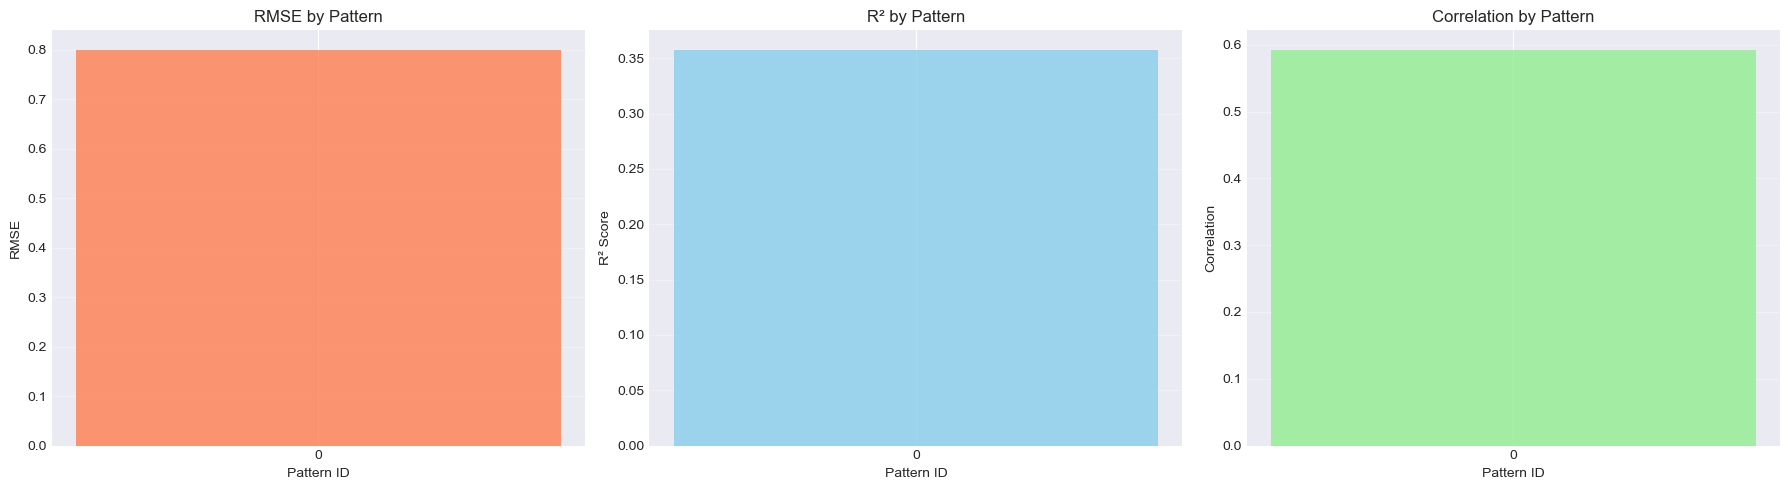

In [10]:
# ============================================================================
# PART 8: PER-PATTERN PERFORMANCE
# ============================================================================

print("\n[8] Analyzing per-pattern performance...\n")

# Collect all test predictions across folds
all_test_predictions = []
all_test_ground_truth = []
all_test_pattern_ids = []

for fold in fold_results:
    test_idx = fold['test_idx']
    all_test_predictions.append(fold['y_pred_test'])
    all_test_ground_truth.append(fold['y_test'])
    all_test_pattern_ids.append(pattern_ids[test_idx])

all_test_predictions = np.concatenate(all_test_predictions, axis=0)
all_test_ground_truth = np.concatenate(all_test_ground_truth, axis=0)
all_test_pattern_ids = np.concatenate(all_test_pattern_ids, axis=0)

# Compute per-pattern metrics
pattern_rmse = []
pattern_r2 = []
pattern_corr = []

for pattern_id in range(exp.n_input_patterns):
    mask = all_test_pattern_ids == pattern_id
    metrics = evaluate_temporal_task(
        all_test_predictions[mask],
        all_test_ground_truth[mask]
    )
    pattern_rmse.append(metrics['rmse_mean'])
    pattern_r2.append(metrics['r2_mean'])
    pattern_corr.append(metrics['correlation_mean'])
    
    print(f"Pattern {pattern_id}: RMSE={metrics['rmse_mean']:.4f}, R²={metrics['r2_mean']:.4f}, Corr={metrics['correlation_mean']:.4f}")

# Plot per-pattern performance
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

x = np.arange(exp.n_input_patterns)

axes[0].bar(x, pattern_rmse, color='coral', alpha=0.8)
axes[0].set_xlabel('Pattern ID')
axes[0].set_ylabel('RMSE')
axes[0].set_title('RMSE by Pattern')
axes[0].set_xticks(x)
axes[0].grid(axis='y', alpha=0.3)

axes[1].bar(x, pattern_r2, color='skyblue', alpha=0.8)
axes[1].set_xlabel('Pattern ID')
axes[1].set_ylabel('R² Score')
axes[1].set_title('R² by Pattern')
axes[1].set_xticks(x)
axes[1].grid(axis='y', alpha=0.3)

axes[2].bar(x, pattern_corr, color='lightgreen', alpha=0.8)
axes[2].set_xlabel('Pattern ID')
axes[2].set_ylabel('Correlation')
axes[2].set_title('Correlation by Pattern')
axes[2].set_xticks(x)
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [24]:
input_patterns[0].sum(),input_patterns[1].sum(),input_patterns[2].sum(),input_patterns[4].sum(),

(-4.547473508864641e-13,
 4.547473508864641e-13,
 1.5916157281026244e-12,
 2.2737367544323206e-13)

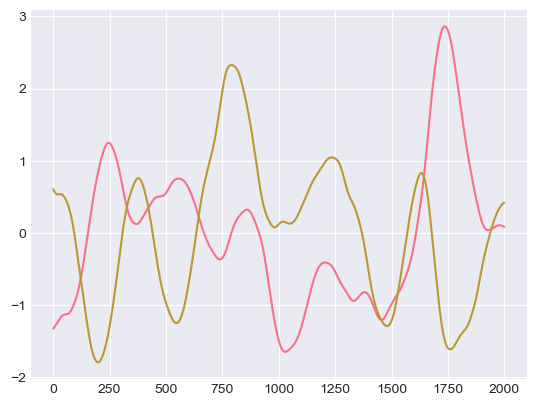

In [20]:
plt.plot(input_patterns[0][:,0])
plt.plot(input_patterns[0][:,-1])

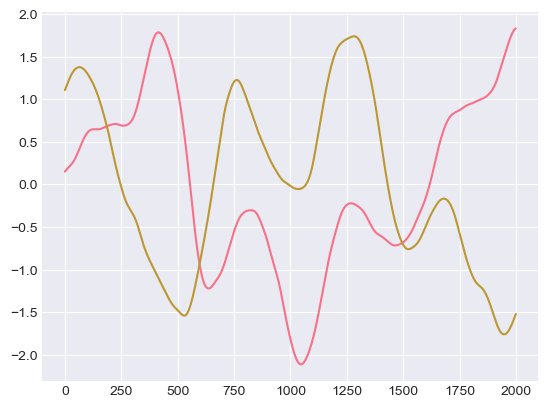

In [19]:
plt.plot(input_patterns[4][:,0])
plt.plot(input_patterns[4][:,-1])


[9] Analyzing readout weights...

Average readout weight shape: (1000, 10)
Weight statistics: min=-0.4422, max=0.3599, mean=0.0006


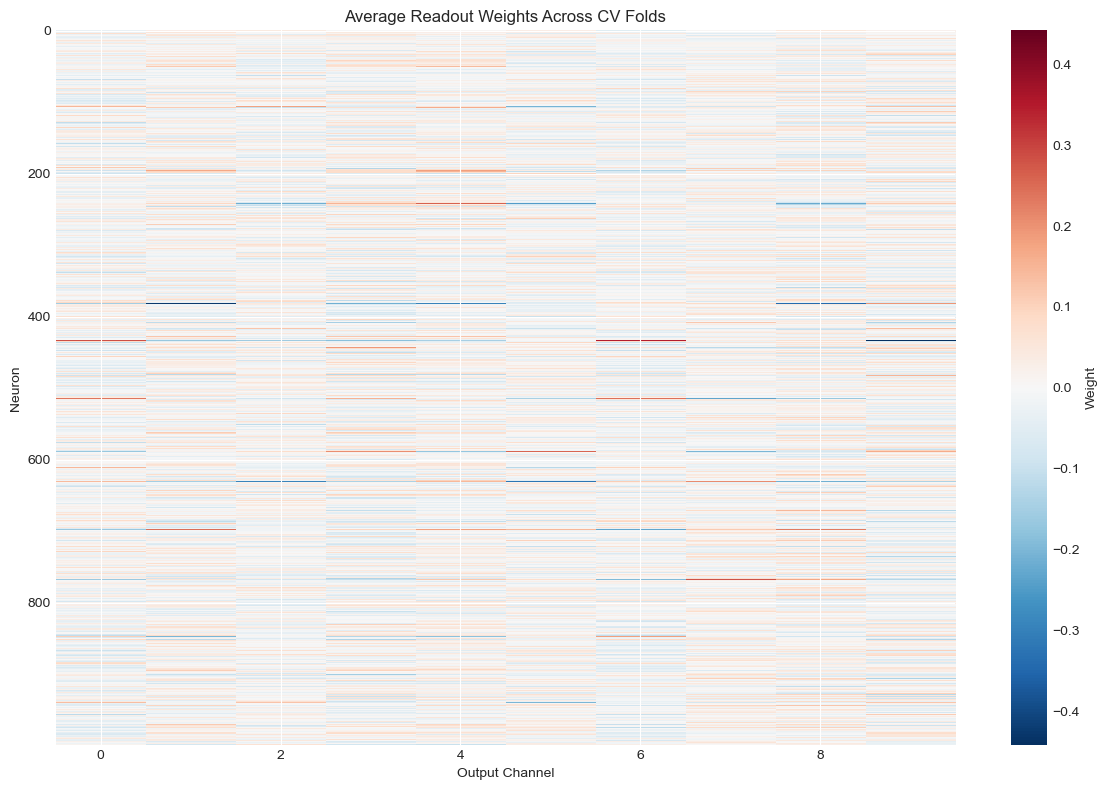

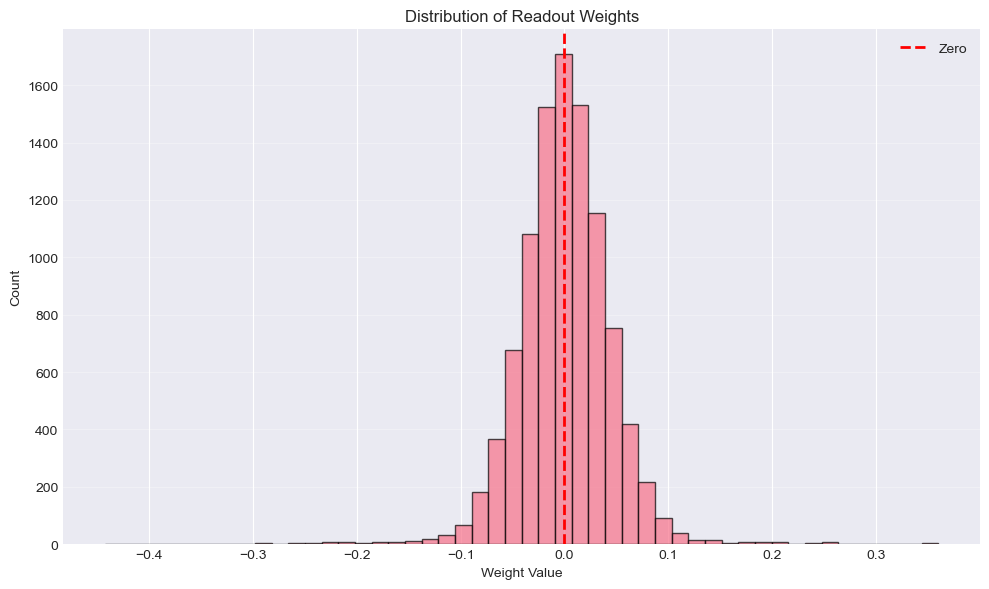

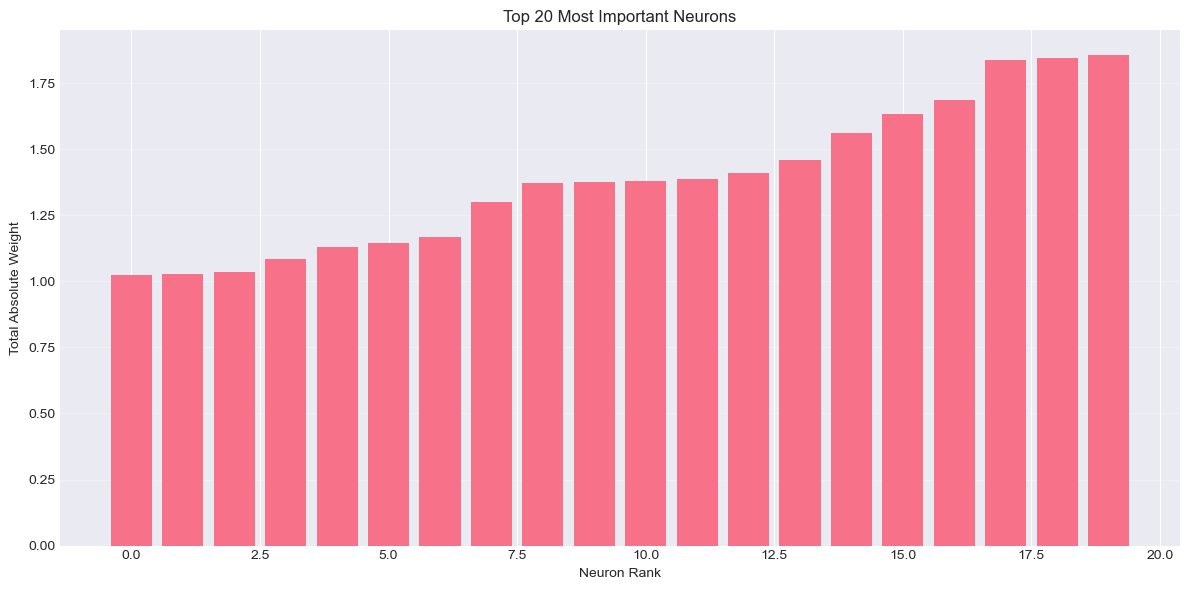


Top 10 neurons by importance: [589 721 145 698 840 563 949 434 382 631]


In [10]:
# ============================================================================
# PART 9: READOUT WEIGHTS ANALYSIS
# ============================================================================

print("\n[9] Analyzing readout weights...\n")

# Average weights across folds
avg_weights = np.mean(all_weights, axis=0)
print(f"Average readout weight shape: {avg_weights.shape}")
print(f"Weight statistics: min={avg_weights.min():.4f}, max={avg_weights.max():.4f}, mean={avg_weights.mean():.4f}")

# Visualize weight matrix
plt.figure(figsize=(12, 8))
im = plt.imshow(avg_weights, aspect='auto', cmap='RdBu_r', interpolation='nearest',
                vmin=-np.abs(avg_weights).max(), vmax=np.abs(avg_weights).max())
plt.colorbar(im, label='Weight')
plt.xlabel('Output Channel')
plt.ylabel('Neuron')
plt.title('Average Readout Weights Across CV Folds')
plt.tight_layout()
plt.show()

# Show weight distribution
plt.figure(figsize=(10, 6))
plt.hist(avg_weights.flatten(), bins=50, alpha=0.7, edgecolor='black')
plt.xlabel('Weight Value')
plt.ylabel('Count')
plt.title('Distribution of Readout Weights')
plt.axvline(0, color='red', linestyle='--', linewidth=2, label='Zero')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Show which neurons contribute most
neuron_importance = np.abs(avg_weights).sum(axis=1)
top_neurons = np.argsort(neuron_importance)[-20:]

plt.figure(figsize=(12, 6))
plt.bar(range(len(top_neurons)), neuron_importance[top_neurons])
plt.xlabel('Neuron Rank')
plt.ylabel('Total Absolute Weight')
plt.title('Top 20 Most Important Neurons')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nTop 10 neurons by importance: {top_neurons[-10:]}")

In [ ]:
print("\n" + "=" * 80)
print("VISUALIZATION COMPLETE!")
print("=" * 80)
print("\nSummary:")
print(f"  • {exp.n_input_patterns} input patterns (HD dim={exp.input_dim_intrinsic})")
print(f"  • {exp.n_input_patterns} output patterns (HD dim={exp.output_dim_intrinsic})")
print(f"  • {n_total_trials} trials simulated")
print(f"  • {n_folds}-fold cross-validation")
print(f"  • Test R² = {np.mean(test_r2):.4f} ± {np.std(test_r2):.4f}")
print(f"  • Test Correlation = {np.mean(test_corr):.4f} ± {np.std(test_corr):.4f}")


[BONUS] Comparing filtering methods...

Kernel length: 250 timesteps (25.0 ms)
Tau: 5.0 ms

Spike matrix shape: (2000, 1000)
Total spikes: 9971.0

Method 1: Simple exponential filter...
  Time: 7.20 ms

Method 2: FFT convolution...
  Time: 310.08 ms

Speedup: 0.02x (Simple faster)


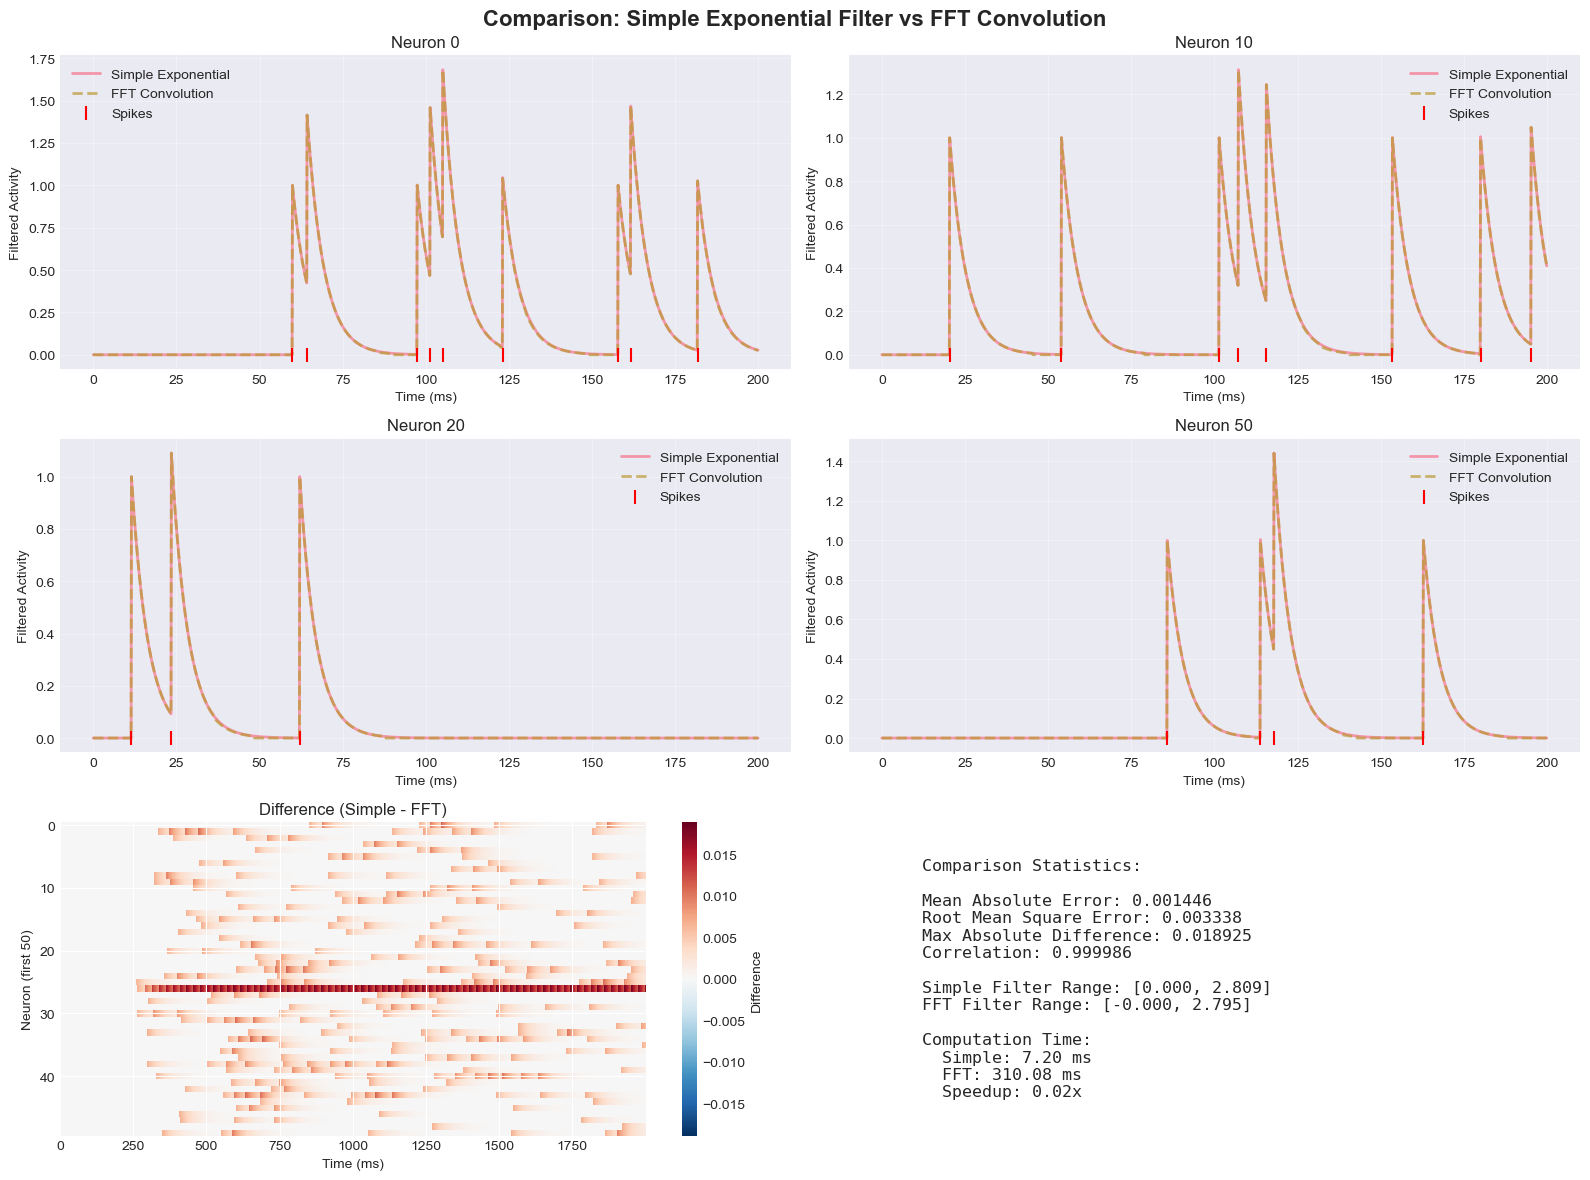


[BONUS] Training readouts with both filtering methods...

FFT traces shape: (200, 2000, 1000)
Simple traces shape: (200, 2000, 1000)


NameError: name 'fold_results' is not defined

In [6]:
# ============================================================================
# COMPARISON: FFT CONVOLUTION vs SIMPLE EXPONENTIAL FILTER
# ============================================================================
import time
print("\n[BONUS] Comparing filtering methods...\n")

# Import both methods
from experiments.experiment_utils import apply_exponential_filter
from analysis.encoding_analysis import filter_spikes_exp_kernel

# Create exponential kernel for FFT method
tau = exp.tau_syn
dt = exp.dt
kernel_fft = np.exp(-np.arange(0, 5 * tau, dt) / tau)

print(f"Kernel length: {len(kernel_fft)} timesteps ({len(kernel_fft)*dt:.1f} ms)")
print(f"Tau: {tau} ms")

# Select one trial for comparison
trial_idx = 0
spike_times_trial = all_trial_results[trial_idx]['spike_times']

# Convert to spike matrix
n_timesteps = int(exp.stimulus_duration / dt)
spike_matrix = spikes_to_matrix(spike_times_trial, n_timesteps, exp.n_neurons, dt)

print(f"\nSpike matrix shape: {spike_matrix.shape}")
print(f"Total spikes: {spike_matrix.sum()}")

# Method 1: Simple exponential filter (task experiments)
print("\nMethod 1: Simple exponential filter...")
start_time = time.time()
filtered_simple = apply_exponential_filter(spike_matrix, tau, dt)
time_simple = time.time() - start_time
print(f"  Time: {time_simple*1000:.2f} ms")

# Method 2: FFT convolution (encoding experiments)
print("\nMethod 2: FFT convolution...")
start_time = time.time()
spike_matrix_3d = spike_matrix[np.newaxis, :, :]  # Add trial dimension
filtered_fft = filter_spikes_exp_kernel(spike_matrix_3d, kernel_fft)[0]  # Remove trial dim
time_fft = time.time() - start_time
print(f"  Time: {time_fft*1000:.2f} ms")

print(f"\nSpeedup: {time_simple/time_fft:.2f}x {'(FFT faster)' if time_fft < time_simple else '(Simple faster)'}")

# ============================================================================
# Visualize the difference
# ============================================================================

fig, axes = plt.subplots(3, 2, figsize=(16, 12))
fig.suptitle('Comparison: Simple Exponential Filter vs FFT Convolution', fontsize=16, fontweight='bold')

# Select a few neurons to show
neurons_to_show = [0, 10, 20, 50]

for i, neuron_idx in enumerate(neurons_to_show):
    if i >= 4:
        break
    
    row = i // 2
    col = i % 2
    ax = axes[row, col] if row < 2 else None
    
    if ax is not None:
        # Plot both filtered traces
        time_axis = np.arange(n_timesteps) * dt
        
        ax.plot(time_axis, filtered_simple[:, neuron_idx], 
                label='Simple Exponential', alpha=0.7, linewidth=2)
        ax.plot(time_axis, filtered_fft[:, neuron_idx], 
                label='FFT Convolution', alpha=0.7, linewidth=2, linestyle='--')
        
        # Mark spike times
        spike_mask = spike_matrix[:, neuron_idx] > 0
        spike_times_neuron = time_axis[spike_mask]
        ax.scatter(spike_times_neuron, np.zeros_like(spike_times_neuron), 
                  color='red', marker='|', s=100, label='Spikes', zorder=3)
        
        ax.set_xlabel('Time (ms)')
        ax.set_ylabel('Filtered Activity')
        ax.set_title(f'Neuron {neuron_idx}')
        ax.legend()
        ax.grid(alpha=0.3)

# Show difference heatmap
ax_diff = axes[2, 0]
difference = filtered_simple - filtered_fft
im = ax_diff.imshow(difference.T[:50], aspect='auto', cmap='RdBu_r', 
                    vmin=-np.abs(difference).max(), vmax=np.abs(difference).max(),
                    interpolation='nearest')
ax_diff.set_xlabel('Time (ms)')
ax_diff.set_ylabel('Neuron (first 50)')
ax_diff.set_title('Difference (Simple - FFT)')
plt.colorbar(im, ax=ax_diff, label='Difference')

# Show statistics
ax_stats = axes[2, 1]
ax_stats.axis('off')

# Compute statistics
mae = np.mean(np.abs(difference))
rmse = np.sqrt(np.mean(difference**2))
max_diff = np.max(np.abs(difference))
correlation = np.corrcoef(filtered_simple.flatten(), filtered_fft.flatten())[0, 1]

stats_text = f"""
Comparison Statistics:

Mean Absolute Error: {mae:.6f}
Root Mean Square Error: {rmse:.6f}
Max Absolute Difference: {max_diff:.6f}
Correlation: {correlation:.6f}

Simple Filter Range: [{filtered_simple.min():.3f}, {filtered_simple.max():.3f}]
FFT Filter Range: [{filtered_fft.min():.3f}, {filtered_fft.max():.3f}]

Computation Time:
  Simple: {time_simple*1000:.2f} ms
  FFT: {time_fft*1000:.2f} ms
  Speedup: {time_simple/time_fft:.2f}x
"""

ax_stats.text(0.1, 0.5, stats_text, fontsize=12, family='monospace',
             verticalalignment='center')

plt.tight_layout()
plt.show()

# ============================================================================
# Compare readout performance with both methods
# ============================================================================

print("\n[BONUS] Training readouts with both filtering methods...\n")

# Use FFT-filtered traces for training
traces_all_fft = np.array([
    filter_spikes_exp_kernel(
        spikes_to_matrix(r['spike_times'], n_timesteps, exp.n_neurons, dt)[np.newaxis, :, :],
        kernel_fft
    )[0]
    for r in all_trial_results
])

print(f"FFT traces shape: {traces_all_fft.shape}")
print(f"Simple traces shape: {traces_all.shape}")

# Train with FFT filtering
from experiments.experiment_utils import train_task_readout, predict_task_readout, evaluate_temporal_task

# Use fold 0 for comparison
train_idx = fold_results[0]['train_idx']
test_idx = fold_results[0]['test_idx']

X_train_simple = traces_all[train_idx]
X_test_simple = traces_all[test_idx]

X_train_fft = traces_all_fft[train_idx]
X_test_fft = traces_all_fft[test_idx]

y_train = ground_truth_all[train_idx]
y_test = ground_truth_all[test_idx]

# Train both readouts
print("Training with simple filter...")
W_simple = train_task_readout(X_train_simple, y_train, exp.lambda_reg)
y_pred_simple = predict_task_readout(X_test_simple, W_simple)
metrics_simple = evaluate_temporal_task(y_pred_simple, y_test)

print("Training with FFT filter...")
W_fft = train_task_readout(X_train_fft, y_train, exp.lambda_reg)
y_pred_fft = predict_task_readout(X_test_fft, W_fft)
metrics_fft = evaluate_temporal_task(y_pred_fft, y_test)

# Compare performance
print("\nReadout Performance Comparison:")
print(f"  Simple Filter:")
print(f"    RMSE: {metrics_simple['rmse_mean']:.4f}")
print(f"    R²:   {metrics_simple['r2_mean']:.4f}")
print(f"    Corr: {metrics_simple['correlation_mean']:.4f}")
print(f"  FFT Convolution:")
print(f"    RMSE: {metrics_fft['rmse_mean']:.4f}")
print(f"    R²:   {metrics_fft['r2_mean']:.4f}")
print(f"    Corr: {metrics_fft['correlation_mean']:.4f}")

# Plot comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

metrics_comparison = {
    'RMSE': [metrics_simple['rmse_mean'], metrics_fft['rmse_mean']],
    'R² Score': [metrics_simple['r2_mean'], metrics_fft['r2_mean']],
    'Correlation': [metrics_simple['correlation_mean'], metrics_fft['correlation_mean']]
}

for ax, (name, values) in zip(axes, metrics_comparison.items()):
    ax.bar(['Simple', 'FFT'], values, alpha=0.8, color=['C0', 'C1'])
    ax.set_ylabel(name)
    ax.set_title(f'{name} Comparison')
    ax.grid(axis='y', alpha=0.3)
    
    # Add values on bars
    for i, v in enumerate(values):
        ax.text(i, v, f'{v:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

print("\n✓ Filtering method comparison complete!")

In [9]:
# ============================================================================
# TEST: Are hd_input_strength=50 and rate_scale=50 equivalent?
# ============================================================================

print("\n[TEST] Comparing hd_input_strength vs rate_scale...\n")

# Setup
session_id = 999
v_th_std = 1.0
g_std = 1.5
pattern_id = 0
trial_id = 100

# Generate a test input pattern
from src.rng_utils import get_rng

base_pattern = input_patterns[pattern_id].copy()

# Add noise (same noise for both tests)
rng = get_rng(session_id, v_th_std, g_std, trial_id,
             f'hd_input_noise_{pattern_id}',
             rate=200.0,
             hd_dim=exp.input_dim_intrinsic,
             embed_dim=exp.input_dim_embedding)

noise = rng.normal(0, 0.5, base_pattern.shape)

# Test Case A: hd_input_strength=50, rate_scale=1
print("Test A: hd_input_strength=50, rate_scale=1")
noisy_input_A = base_pattern + noise
noisy_input_A = noisy_input_A - np.min(noisy_input_A)
noisy_input_A = noisy_input_A * 1.0  # rate_scale=1

print(f"  Input range: [{noisy_input_A.min():.2f}, {noisy_input_A.max():.2f}]")
print(f"  Input mean: {noisy_input_A.mean():.2f}")

# Create network with hd_input_strength=50
from src.spiking_network import SpikingRNN

network_A = SpikingRNN(
    n_neurons=exp.n_neurons,
    dt=exp.dt,
    synaptic_mode=exp.synaptic_mode,
    static_input_mode=exp.static_input_mode,
    hd_input_mode=exp.hd_input_mode,
    n_hd_channels=exp.input_dim_embedding,
    use_readout_synapses=False
)

network_A.initialize_network(
    session_id=session_id,
    v_th_std=v_th_std,
    g_std=g_std,
    hd_dim=exp.input_dim_intrinsic,
    embed_dim=exp.input_dim_embedding,
    static_input_strength=10.0,
    hd_connection_prob=0.3,
    hd_input_strength=50.0  # ← Strong synapses
)

# Run simulation
spike_times_A, _ = network_A.simulate_encoding_task(
    session_id=session_id,
    v_th_std=v_th_std,
    g_std=g_std,
    trial_id=trial_id,
    duration=exp.total_duration,
    hd_input_patterns=noisy_input_A,
    hd_dim=exp.input_dim_intrinsic,
    embed_dim=exp.input_dim_embedding,
    static_input_rate=30.0,
    transient_time=exp.transient_time
)

spikes_A = [(t - exp.transient_time, nid) for t, nid in spike_times_A if t >= exp.transient_time]
print(f"  Total spikes: {len(spikes_A)}")

# Test Case B: hd_input_strength=1, rate_scale=50
print("\nTest B: hd_input_strength=1, rate_scale=50")
noisy_input_B = base_pattern + noise
noisy_input_B = noisy_input_B - np.min(noisy_input_B)
noisy_input_B = noisy_input_B * 50.0  # rate_scale=50

print(f"  Input range: [{noisy_input_B.min():.2f}, {noisy_input_B.max():.2f}]")
print(f"  Input mean: {noisy_input_B.mean():.2f}")

# Create network with hd_input_strength=1
network_B = SpikingRNN(
    n_neurons=exp.n_neurons,
    dt=exp.dt,
    synaptic_mode=exp.synaptic_mode,
    static_input_mode=exp.static_input_mode,
    hd_input_mode=exp.hd_input_mode,
    n_hd_channels=exp.input_dim_embedding,
    use_readout_synapses=False
)

network_B.initialize_network(
    session_id=session_id,
    v_th_std=v_th_std,
    g_std=g_std,
    hd_dim=exp.input_dim_intrinsic,
    embed_dim=exp.input_dim_embedding,
    static_input_strength=10.0,
    hd_connection_prob=0.3,
    hd_input_strength=1.0  # ← Normal synapses
)

# Run simulation
spike_times_B, _ = network_B.simulate_encoding_task(
    session_id=session_id,
    v_th_std=v_th_std,
    g_std=g_std,
    trial_id=trial_id,
    duration=exp.total_duration,
    hd_input_patterns=noisy_input_B,
    hd_dim=exp.input_dim_intrinsic,
    embed_dim=exp.input_dim_embedding,
    static_input_rate=30.0,
    transient_time=exp.transient_time
)

spikes_B = [(t - exp.transient_time, nid) for t, nid in spike_times_B if t >= exp.transient_time]
print(f"  Total spikes: {len(spikes_B)}")

# Compare
print("\n" + "="*60)
print("COMPARISON:")
print("="*60)
print(f"Test A spike count: {len(spikes_A)}")
print(f"Test B spike count: {len(spikes_B)}")
print(f"Difference: {abs(len(spikes_A) - len(spikes_B))} spikes")

if len(spikes_A) == len(spikes_B):
    # Check if spike times are identical
    if spikes_A == spikes_B:
        print("\n✓✓✓ PERFECTLY EQUIVALENT: Identical spike times!")
    else:
        # Check how similar they are
        times_A = set(spikes_A)
        times_B = set(spikes_B)
        common = times_A & times_B
        print(f"\n≈ VERY SIMILAR: {len(common)}/{len(spikes_A)} spikes match ({100*len(common)/len(spikes_A):.1f}%)")
else:
    diff_pct = 100 * abs(len(spikes_A) - len(spikes_B)) / max(len(spikes_A), len(spikes_B))
    print(f"\n✗ DIFFERENT: {diff_pct:.1f}% difference in spike counts")
    
print("\n" + "="*60)


[TEST] Comparing hd_input_strength vs rate_scale...

Test A: hd_input_strength=50, rate_scale=1
  Input range: [0.00, 7.08]
  Input mean: 3.22
  Total spikes: 7106

Test B: hd_input_strength=1, rate_scale=50
  Input range: [0.00, 353.85]
  Input mean: 161.09
  Total spikes: 11516

COMPARISON:
Test A spike count: 7106
Test B spike count: 11516
Difference: 4410 spikes

✗ DIFFERENT: 38.3% difference in spike counts



In [10]:
# After creating both networks, compare them:
print("\nNetwork comparison:")
print(f"Network A threshold mean: {network_A.neurons.spike_thresholds.mean():.4f}")
print(f"Network B threshold mean: {network_B.neurons.spike_thresholds.mean():.4f}")

print(f"Network A recurrent weight sum: {network_A.recurrent_synapses.weight_matrix.sum():.4f}")
print(f"Network B recurrent weight sum: {network_B.recurrent_synapses.weight_matrix.sum():.4f}")

print(f"Network A HD weight sum: {network_A.hd_input_synapses.weight_matrix.sum():.4f}")
print(f"Network B HD weight sum: {network_B.hd_input_synapses.weight_matrix.sum():.4f}")

if network_A.neurons.spike_thresholds.mean() != network_B.neurons.spike_thresholds.mean():
    print("\n✗ Networks are DIFFERENT! This explains the spike count difference.")
else:
    print("\n✓ Networks are identical (as expected)")


Network comparison:
Network A threshold mean: -55.0000
Network B threshold mean: -55.0000
Network A recurrent weight sum: -0.0000
Network B recurrent weight sum: -0.0000


AttributeError: 'NoneType' object has no attribute 'sum'

In [12]:
# ============================================================================
# PROPER TEST: Same network, different input scaling
# ============================================================================

print("\n[PROPER TEST] Same network, different input scaling...\n")

# Create ONE network
test_network = SpikingRNN(
    n_neurons=exp.n_neurons,
    dt=exp.dt,
    synaptic_mode=exp.synaptic_mode,
    static_input_mode=exp.static_input_mode,
    hd_input_mode=exp.hd_input_mode,
    n_hd_channels=exp.input_dim_embedding,
    use_readout_synapses=False
)

# Initialize with hd_input_strength=1 (we'll scale the input instead)
test_network.initialize_network(
    session_id=session_id,
    v_th_std=v_th_std,
    g_std=g_std,
    hd_dim=exp.input_dim_intrinsic,
    embed_dim=exp.input_dim_embedding,
    static_input_strength=10.0,
    hd_connection_prob=0.3,
    hd_input_strength=1.0  # Base strength
)

print("Network initialized")
print(f"  HD input synapses: {test_network.hd_input_synapses}")

if test_network.hd_input_synapses is not None:
    print(f"  HD weight matrix shape: {test_network.hd_input_synapses.weight_matrix.shape}")
    print(f"  HD weight sum: {test_network.hd_input_synapses.weight_matrix.sum():.4f}")
    
    # Manually scale the HD weight matrix for test A
    original_weights = test_network.hd_input_synapses.weight_matrix.copy()
    
    # Test A: Scale weights by 50x
    print("\nTest A: Scale HD weights by 50x")
    test_network.hd_input_synapses.weight_matrix = original_weights * 50.0
    
    # Prepare input (rate_scale=1)
    noisy_input_1 = base_pattern + noise
    noisy_input_1 = noisy_input_1 - np.min(noisy_input_1)
    noisy_input_1 = noisy_input_1 * 1.0
    
    # Run simulation (without static input to isolate HD input effect)
    spike_times_test_A, _ = test_network.simulate_encoding_task(
        session_id=session_id,
        v_th_std=v_th_std,
        g_std=g_std,
        trial_id=trial_id,
        duration=exp.total_duration,
        hd_input_patterns=noisy_input_1,
        hd_dim=exp.input_dim_intrinsic,
        embed_dim=exp.input_dim_embedding,
        static_input_rate=0.0,  # ← NO static input
        transient_time=exp.transient_time
    )
    
    spikes_test_A = [(t - exp.transient_time, nid) for t, nid in spike_times_test_A if t >= exp.transient_time]
    print(f"  Spikes: {len(spikes_test_A)}")
    
    # Test B: Reset weights to original, scale input by 50x
    print("\nTest B: Reset weights, scale input by 50x")
    test_network.hd_input_synapses.weight_matrix = original_weights.copy()
    
    # Prepare input (rate_scale=50)
    noisy_input_50 = base_pattern + noise
    noisy_input_50 = noisy_input_50 - np.min(noisy_input_50)
    noisy_input_50 = noisy_input_50 * 50.0
    
    # Reset network state
    test_network.neurons.reset_state()
    test_network.recurrent_synapses.reset_state()
    test_network.hd_input_synapses.reset_state()
    test_network.static_input_synapses.reset_state()
    
    # Run simulation
    spike_times_test_B, _ = test_network.simulate_encoding_task(
        session_id=session_id,
        v_th_std=v_th_std,
        g_std=g_std,
        trial_id=trial_id,
        duration=exp.total_duration,
        hd_input_patterns=noisy_input_50,
        hd_dim=exp.input_dim_intrinsic,
        embed_dim=exp.input_dim_embedding,
        static_input_rate=0.0,  # ← NO static input
        transient_time=exp.transient_time
    )
    
    spikes_test_B = [(t - exp.transient_time, nid) for t, nid in spike_times_test_B if t >= exp.transient_time]
    print(f"  Spikes: {len(spikes_test_B)}")
    
    # Compare
    print("\n" + "="*60)
    print("PROPER COMPARISON (same network, no static input):")
    print("="*60)
    print(f"Test A (W×50, input×1): {len(spikes_test_A)} spikes")
    print(f"Test B (W×1, input×50): {len(spikes_test_B)} spikes")
    print(f"Difference: {abs(len(spikes_test_A) - len(spikes_test_B))} spikes")
    
    if abs(len(spikes_test_A) - len(spikes_test_B)) < 10:
        print("\n✓ EQUIVALENT (within numerical tolerance)")
    else:
        diff_pct = 100 * abs(len(spikes_test_A) - len(spikes_test_B)) / max(len(spikes_test_A), len(spikes_test_B))
        print(f"\n✗ DIFFERENT ({diff_pct:.1f}% difference)")
        print("Possible reasons: synaptic filtering, numerical precision, or static input contamination")

else:
    print("\n✗ Cannot perform test - HD input synapses not initialized!")


[PROPER TEST] Same network, different input scaling...

Network initialized
  HD input synapses: <src.synaptic_model.Synapse object at 0x143918aa0>


AttributeError: 'NoneType' object has no attribute 'shape'


TEST: Does changing hd_input_strength affect network spikes?

Input pattern:
  Shape: (2000, 10)
  Range: [0.000, 7.262]
  Mean: 3.669

Simulation parameters:
  Transient time: 200.0 ms
  Stimulus duration: 200.0 ms
  Total duration: 400.0 ms

Testing hd_input_strength = 1.0
  HD input object: <src.synaptic_model.HDDynamicInput object at 0x15bee5670>
  HD input strength stored: 1.0
  HD input connectivity initialized: True
  Total HD connections: 2968
  Result: 0 spikes
  ⚠️  NO SPIKES! HD input has NO EFFECT!

Testing hd_input_strength = 50.0
  HD input object: <src.synaptic_model.HDDynamicInput object at 0x15bee52e0>
  HD input strength stored: 50.0
  HD input connectivity initialized: True
  Total HD connections: 2968
  Result: 15182 spikes
  First spike time: 5.8 ms
  Last spike time: 199.9 ms
  Average firing rate: 75.91 Hz

RESULTS SUMMARY
  hd_input_strength =   1.0 →     0 spikes
  hd_input_strength =  50.0 → 15182 spikes

✓ hd_input_strength DOES affect spike counts!

Spike c

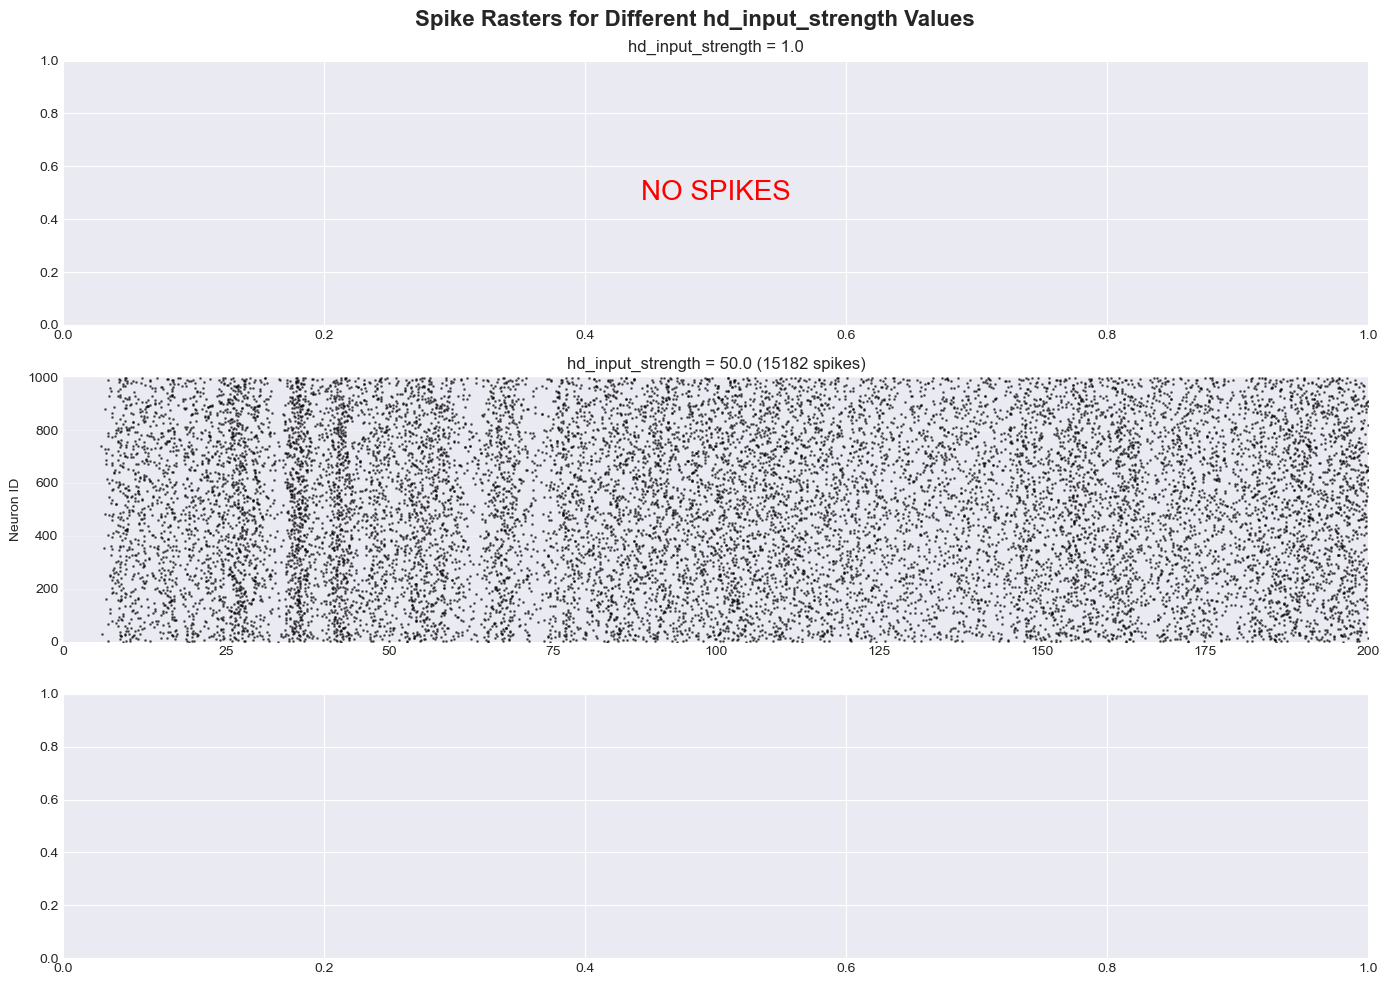


TEST COMPLETE


In [11]:
# ============================================================================
# TEST: Does hd_input_strength actually affect network spikes?
# ============================================================================

print("\n" + "="*80)
print("TEST: Does changing hd_input_strength affect network spikes?")
print("="*80)

# Fixed parameters
session_id = 999
v_th_std = .0
g_std = 1.
trial_id = 100
pattern_id = 0

# Generate ONE input pattern (will be used for all tests)
base_pattern = input_patterns[pattern_id].copy()

from src.rng_utils import get_rng
rng = get_rng(session_id, v_th_std, g_std, trial_id,
             f'hd_input_noise_{pattern_id}',
             rate=30.0,
             hd_dim=exp.input_dim_intrinsic,
             embed_dim=exp.input_dim_embedding)

noise = rng.normal(0, 0.5, base_pattern.shape)
noisy_input = base_pattern + noise
noisy_input = noisy_input - np.min(noisy_input)
noisy_input = noisy_input * 1.0  # Keep scale at 1.0

print(f"\nInput pattern:")
print(f"  Shape: {noisy_input.shape}")
print(f"  Range: [{noisy_input.min():.3f}, {noisy_input.max():.3f}]")
print(f"  Mean: {noisy_input.mean():.3f}")

# Get duration parameters
transient_time = 200.0  # ms
stimulus_duration = exp.stimulus_duration  # ms
total_duration = transient_time + stimulus_duration

print(f"\nSimulation parameters:")
print(f"  Transient time: {transient_time} ms")
print(f"  Stimulus duration: {stimulus_duration} ms")
print(f"  Total duration: {total_duration} ms")

# Test 3 different hd_input_strength values
strength_values = [1.0, 50.0]
spike_counts = []
spike_times_list = []

for strength in strength_values:
    print(f"\n{'='*60}")
    print(f"Testing hd_input_strength = {strength}")
    print(f"{'='*60}")
    
    # Create network
    from src.spiking_network import SpikingRNN
    
    test_net = SpikingRNN(
        n_neurons=exp.n_neurons,
        dt=exp.dt,
        synaptic_mode=exp.synaptic_mode,
        static_input_mode="common_tonic",
        hd_input_mode="common_tonic",
        n_hd_channels=exp.input_dim_embedding,
        use_readout_synapses=False
    )
    
    # Initialize network with this strength
    test_net.initialize_network(
        session_id=session_id,
        v_th_std=v_th_std,
        g_std=g_std,
        v_th_distribution='normal',
        hd_dim=exp.input_dim_intrinsic,
        embed_dim=exp.input_dim_embedding,
        static_input_strength=10.0,
        hd_connection_prob=0.3,
        hd_input_strength=strength  # ← THE PARAMETER WE'RE TESTING
    )
    
    # Check if HD input is actually initialized
    print(f"  HD input object: {test_net.hd_input}")
    print(f"  HD input strength stored: {test_net.hd_input.input_strength}")
    print(f"  HD input connectivity initialized: {test_net.hd_input.connectivity_matrix is not None}")
    
    if test_net.hd_input.connectivity_matrix is not None:
        conn_sum = test_net.hd_input.connectivity_matrix.sum()
        print(f"  Total HD connections: {conn_sum}")
    
    # Run simulation with NO static input (to isolate HD input effect)
    spike_times, _ = test_net.simulate_encoding_task(
        session_id=session_id,
        v_th_std=v_th_std,
        g_std=g_std,
        trial_id=trial_id,
        duration=total_duration,
        hd_input_patterns=noisy_input,
        hd_dim=exp.input_dim_intrinsic,
        embed_dim=exp.input_dim_embedding,
        static_input_rate=0.0,  # ← NO static input!
        transient_time=transient_time
    )
    
    # Extract encoding period spikes
    encoding_spikes = [(t - transient_time, nid) 
                      for t, nid in spike_times 
                      if t >= transient_time]
    
    n_spikes = len(encoding_spikes)
    spike_counts.append(n_spikes)
    spike_times_list.append(encoding_spikes)
    
    print(f"  Result: {n_spikes} spikes")
    
    if n_spikes > 0:
        spike_times_only = [t for t, nid in encoding_spikes]
        print(f"  First spike time: {min(spike_times_only):.1f} ms")
        print(f"  Last spike time: {max(spike_times_only):.1f} ms")
        print(f"  Average firing rate: {n_spikes / (exp.n_neurons * stimulus_duration / 1000):.2f} Hz")
    else:
        print(f"  ⚠️  NO SPIKES! HD input has NO EFFECT!")

# ============================================================================
# ANALYSIS
# ============================================================================

print("\n" + "="*80)
print("RESULTS SUMMARY")
print("="*80)

for strength, count in zip(strength_values, spike_counts):
    print(f"  hd_input_strength = {strength:5.1f} → {count:5d} spikes")

# Check if strength affects spike count
if spike_counts[0] == spike_counts[1] == spike_counts[2]:
    print("\n✗✗✗ BUG CONFIRMED: hd_input_strength has NO EFFECT!")
    print("     All three strengths produced IDENTICAL spike counts!")
    
elif spike_counts[0] == 0 and spike_counts[1] == 0 and spike_counts[2] == 0:
    print("\n✗✗✗ BUG CONFIRMED: HD input produces NO SPIKES!")
    print("     The HD input is not reaching the network!")
    
else:
    # Check if spike counts increase with strength
    ratios = []
    for i in range(len(strength_values)-1):
        if spike_counts[i] > 0:
            ratio = spike_counts[i+1] / spike_counts[i]
            expected_ratio = strength_values[i+1] / strength_values[i]
            ratios.append((ratio, expected_ratio))
    
    print(f"\n✓ hd_input_strength DOES affect spike counts!")
    print(f"\nSpike count ratios:")
    
    for i, (ratio, expected) in enumerate(ratios):
        print(f"  strength_{strength_values[i+1]}/strength_{strength_values[i]} = {ratio:.2f} (expected ~{expected:.1f})")
    
    # Check if ratios are approximately correct
    all_correct = all(abs(ratio - expected) < expected * 0.5 for ratio, expected in ratios)
    
    if all_correct:
        print(f"\n✓✓✓ WORKING CORRECTLY: Spike counts scale appropriately with hd_input_strength")
    else:
        print(f"\n⚠️  Spike counts change but NOT proportionally to hd_input_strength")

# Visualize spike rasters
import matplotlib.pyplot as plt

if any(count > 0 for count in spike_counts):
    fig, axes = plt.subplots(3, 1, figsize=(14, 10))
    fig.suptitle('Spike Rasters for Different hd_input_strength Values', 
                 fontsize=16, fontweight='bold')
    
    for idx, (strength, spikes) in enumerate(zip(strength_values, spike_times_list)):
        ax = axes[idx]
        
        if len(spikes) > 0:
            times = [t for t, nid in spikes]
            neurons = [nid for t, nid in spikes]
            
            ax.scatter(times, neurons, s=1, alpha=0.5, c='black')
            ax.set_ylabel('Neuron ID')
            ax.set_title(f'hd_input_strength = {strength} ({len(spikes)} spikes)')
            ax.set_xlim(0, stimulus_duration)
            ax.set_ylim(0, exp.n_neurons)
            ax.grid(alpha=0.3)
        else:
            ax.text(0.5, 0.5, 'NO SPIKES', 
                   transform=ax.transAxes, ha='center', va='center',
                   fontsize=20, color='red')
            ax.set_title(f'hd_input_strength = {strength}')
        
        if idx == 2:
            ax.set_xlabel('Time (ms)')
    
    plt.tight_layout()
    plt.show()
else:
    print("\n⚠️  Cannot plot raster - no spikes in any condition!")

print("\n" + "="*80)
print("TEST COMPLETE")
print("="*80)

In [1]:
# ============================================================================
# PART 1: CREATE EXPERIMENT AND GENERATE PATTERNS
# ============================================================================

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
import sys
import os

# Add project paths
sys.path.insert(0, os.path.abspath('.'))
sys.path.insert(0, os.path.abspath('./experiments'))
sys.path.insert(0, os.path.abspath('./src'))

from experiments.task_performance_experiment import TaskPerformanceExperiment
from experiments.experiment_utils import (
    apply_exponential_filter, 
    train_task_readout, 
    predict_task_readout,
    evaluate_categorical_task
)
from analysis.common_utils import spikes_to_matrix

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 8)
plt.rcParams['font.size'] = 10

# ============================================================================
# EXPERIMENT CONFIGURATION
# ============================================================================

# Network parameters
SESSION_ID = 42
N_NEURONS = 1000
N_INPUT_PATTERNS = 4  # 4 classes
N_TRIALS_PER_PATTERN = 100  # 50 trials per class (200 total)

# Heterogeneity
V_TH_STD = 0.
G_STD = 1.
STATIC_INPUT_RATE = 30.0

# HD input
INPUT_HD_DIM = 1
INPUT_EMBED_DIM = 5

# Task parameters
STIMULUS_DURATION = 200.0  # ms
DECISION_WINDOW = STIMULUS_DURATION
TAU_SYN = 5.0
LAMBDA_REG = 1e-3
DT = 0.1

print("=" * 80)
print("CATEGORICAL CLASSIFICATION EXPERIMENT")
print("=" * 80)
print(f"Network: {N_NEURONS} neurons")
print(f"Classes: {N_INPUT_PATTERNS}")
print(f"Trials per class: {N_TRIALS_PER_PATTERN}")
print(f"Total trials: {N_INPUT_PATTERNS * N_TRIALS_PER_PATTERN}")
print(f"Heterogeneity: v_th_std={V_TH_STD}, g_std={G_STD}")
print(f"Input: HD dim={INPUT_HD_DIM}, embed dim={INPUT_EMBED_DIM}")
print(f"Duration: {STIMULUS_DURATION} ms")
print("=" * 80)

# Create experiment
experiment = TaskPerformanceExperiment(
    task_type='categorical',
    n_neurons=N_NEURONS,
    n_input_patterns=N_INPUT_PATTERNS,
    input_dim_intrinsic=INPUT_HD_DIM,
    input_dim_embedding=INPUT_EMBED_DIM,
    output_dim_intrinsic=N_INPUT_PATTERNS,  # One-hot encoding
    output_dim_embedding=N_INPUT_PATTERNS,
    dt=DT,
    tau_syn=TAU_SYN,
    synaptic_mode="filter",
    static_input_mode="common_tonic",
    hd_input_mode="common_tonic",
    signal_cache_dir="hd_signals/notebook_demo",
    stimulus_duration=STIMULUS_DURATION,
    decision_window=DECISION_WINDOW,
    n_trials_per_pattern=N_TRIALS_PER_PATTERN,
    lambda_reg=LAMBDA_REG
)

# Generate input patterns
print("\nGenerating input patterns...")
input_patterns = experiment.initialize_and_get_patterns(
    session_id=SESSION_ID,
    hd_dim=INPUT_HD_DIM,
    n_patterns=N_INPUT_PATTERNS
)

# Generate output patterns (one-hot encoded)
print("Generating output patterns (one-hot)...")
output_patterns = experiment.generate_output_patterns(SESSION_ID)

print("\n✓ Patterns generated successfully!")
print(f"  Input pattern shape: {input_patterns[0].shape}")
print(f"  Output pattern shape: {output_patterns[0].shape}")

CATEGORICAL CLASSIFICATION EXPERIMENT
Network: 1000 neurons
Classes: 4
Trials per class: 100
Total trials: 400
Heterogeneity: v_th_std=0.0, g_std=1.0
Input: HD dim=1, embed dim=5
Duration: 200.0 ms

Generating input patterns...
Generating output patterns (one-hot)...

✓ Patterns generated successfully!
  Input pattern shape: (2000, 5)
  Output pattern shape: (2000, 4)


/var/folders/vq/wqh08z6d6wbcm3z2r206cfn00000gn/T/ipykernel_3819/3793913262.py:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


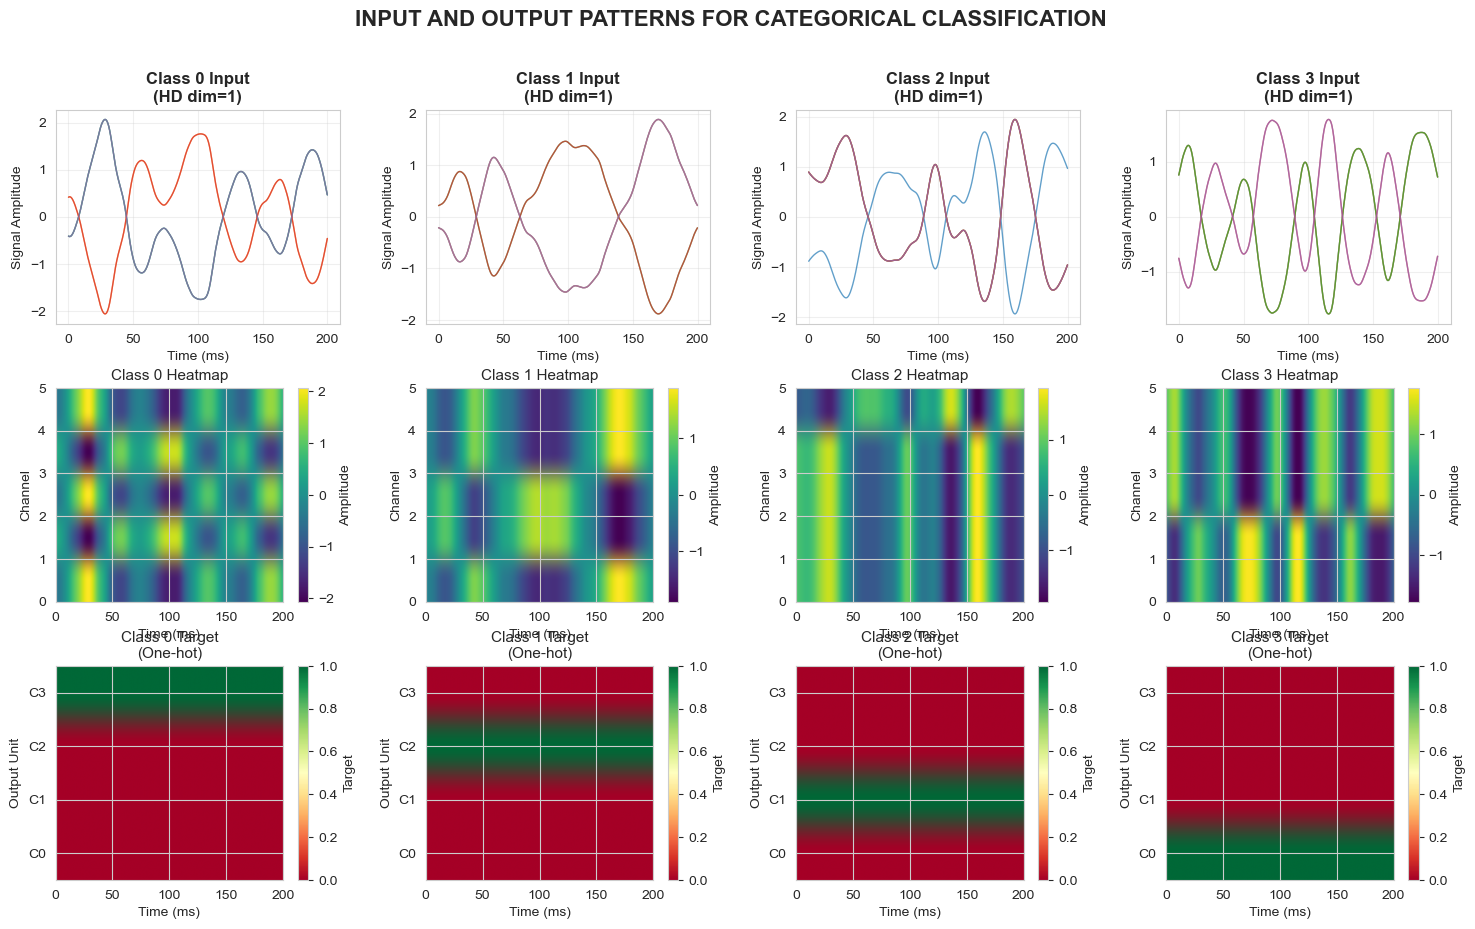


Pattern Statistics:
------------------------------------------------------------
Class 0:
  Input:  mean=0.000, std=1.000, range=[-2.065, 2.065]
  Output: one-hot vector at position 0
Class 1:
  Input:  mean=-0.000, std=1.000, range=[-1.886, 1.886]
  Output: one-hot vector at position 1
Class 2:
  Input:  mean=-0.000, std=1.000, range=[-1.942, 1.942]
  Output: one-hot vector at position 2
Class 3:
  Input:  mean=-0.000, std=1.000, range=[-1.769, 1.769]
  Output: one-hot vector at position 3


In [2]:
# ============================================================================
# PART 2: VISUALIZE INPUT AND OUTPUT PATTERNS
# ============================================================================

fig = plt.figure(figsize=(18, 10))
gs = GridSpec(3, N_INPUT_PATTERNS, figure=fig, hspace=0.3, wspace=0.3)

# Row 1: Input patterns (time series)
for pattern_id in range(N_INPUT_PATTERNS):
    ax = fig.add_subplot(gs[0, pattern_id])
    input_pattern = input_patterns[pattern_id]
    
    # Plot each channel
    time_ms = np.arange(input_pattern.shape[0]) * DT
    for channel in range(min(INPUT_EMBED_DIM, 5)):  # Show first 5 channels
        ax.plot(time_ms, input_pattern[:, channel], alpha=0.7, linewidth=1)
    
    ax.set_title(f'Class {pattern_id} Input\n(HD dim={INPUT_HD_DIM})', fontsize=12, fontweight='bold')
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Signal Amplitude')
    ax.grid(True, alpha=0.3)

# Row 2: Input patterns (heatmap)
for pattern_id in range(N_INPUT_PATTERNS):
    ax = fig.add_subplot(gs[1, pattern_id])
    input_pattern = input_patterns[pattern_id]
    
    im = ax.imshow(input_pattern.T, aspect='auto', cmap='viridis', 
                   extent=[0, STIMULUS_DURATION, 0, INPUT_EMBED_DIM])
    ax.set_title(f'Class {pattern_id} Heatmap', fontsize=11)
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Channel')
    plt.colorbar(im, ax=ax, label='Amplitude')

# Row 3: Output patterns (one-hot encoding)
for pattern_id in range(N_INPUT_PATTERNS):
    ax = fig.add_subplot(gs[2, pattern_id])
    output_pattern = output_patterns[pattern_id]
    
    im = ax.imshow(output_pattern.T, aspect='auto', cmap='RdYlGn', 
                   extent=[0, STIMULUS_DURATION, 0, N_INPUT_PATTERNS])
    ax.set_title(f'Class {pattern_id} Target\n(One-hot)', fontsize=11)
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Output Unit')
    ax.set_yticks(np.arange(N_INPUT_PATTERNS) + 0.5)
    ax.set_yticklabels([f'C{i}' for i in range(N_INPUT_PATTERNS)])
    plt.colorbar(im, ax=ax, label='Target')

plt.suptitle('INPUT AND OUTPUT PATTERNS FOR CATEGORICAL CLASSIFICATION', 
             fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

# Pattern statistics
print("\nPattern Statistics:")
print("-" * 60)
for pattern_id in range(N_INPUT_PATTERNS):
    inp = input_patterns[pattern_id]
    out = output_patterns[pattern_id]
    print(f"Class {pattern_id}:")
    print(f"  Input:  mean={inp.mean():.3f}, std={inp.std():.3f}, range=[{inp.min():.3f}, {inp.max():.3f}]")
    print(f"  Output: one-hot vector at position {np.argmax(out[0])}")

In [3]:
# ============================================================================
# PART 3: SIMULATE TRIALS
# ============================================================================

print("=" * 80)
print("SIMULATING NETWORK TRIALS")
print("=" * 80)

# Generate trial indices
all_trials = []
for pattern_id in range(N_INPUT_PATTERNS):
    for trial_idx in range(N_TRIALS_PER_PATTERN):
        trial_global_idx = pattern_id * N_TRIALS_PER_PATTERN + trial_idx
        all_trials.append(trial_global_idx)

print(f"\nSimulating {len(all_trials)} trials...")
print("This may take several minutes...\n")

# Simulate all trials
trial_results = []
for i, trial_idx in enumerate(all_trials):
    # Decode trial index
    pattern_id = trial_idx // N_TRIALS_PER_PATTERN
    trial_within_pattern = trial_idx % N_TRIALS_PER_PATTERN
    
    # Generate noisy input
    base_pattern = input_patterns[pattern_id]
    from src.rng_utils import get_rng
    rng = get_rng(SESSION_ID, V_TH_STD, G_STD, trial_idx,
                  f'hd_input_noise_{pattern_id}',
                  rate=STATIC_INPUT_RATE,
                  hd_dim=INPUT_HD_DIM,
                  embed_dim=INPUT_EMBED_DIM)
    
    noise = rng.normal(0, 0.5, base_pattern.shape)
    noisy_input = base_pattern + noise
    noisy_input = noisy_input - np.min(noisy_input)
    
    # Run trial
    trial_result = experiment.run_single_trial(
        session_id=SESSION_ID,
        v_th_std=V_TH_STD,
        g_std=G_STD,
        trial_id=trial_idx,
        pattern_id=pattern_id,
        noisy_input_pattern=noisy_input,
        static_input_rate=STATIC_INPUT_RATE,
        v_th_distribution="normal"
    )
    
    trial_result['global_trial_idx'] = trial_idx
    trial_results.append(trial_result)
    
    if (i + 1) % 20 == 0:
        print(f"  Completed {i+1}/{len(all_trials)} trials ({(i+1)/len(all_trials)*100:.1f}%)")

print(f"\n✓ All {len(trial_results)} trials completed!")

# Statistics
n_spikes_per_trial = [len(t['spike_times']) for t in trial_results]
print(f"\nSpike Statistics:")
print(f"  Mean spikes per trial: {np.mean(n_spikes_per_trial):.1f}")
print(f"  Std spikes per trial: {np.std(n_spikes_per_trial):.1f}")
print(f"  Range: [{np.min(n_spikes_per_trial)}, {np.max(n_spikes_per_trial)}]")

SIMULATING NETWORK TRIALS

Simulating 400 trials...
This may take several minutes...

  Completed 20/400 trials (5.0%)
  Completed 40/400 trials (10.0%)
  Completed 60/400 trials (15.0%)
  Completed 80/400 trials (20.0%)
  Completed 100/400 trials (25.0%)
  Completed 120/400 trials (30.0%)
  Completed 140/400 trials (35.0%)
  Completed 160/400 trials (40.0%)
  Completed 180/400 trials (45.0%)
  Completed 200/400 trials (50.0%)
  Completed 220/400 trials (55.0%)
  Completed 240/400 trials (60.0%)
  Completed 260/400 trials (65.0%)
  Completed 280/400 trials (70.0%)
  Completed 300/400 trials (75.0%)
  Completed 320/400 trials (80.0%)
  Completed 340/400 trials (85.0%)
  Completed 360/400 trials (90.0%)
  Completed 380/400 trials (95.0%)
  Completed 400/400 trials (100.0%)

✓ All 400 trials completed!

Spike Statistics:
  Mean spikes per trial: 16224.2
  Std spikes per trial: 495.8
  Range: [15047, 18579]


CONVERTING SPIKES TO FILTERED TRACES

Converting 400 trials to traces...
✓ Conversion complete!
  Traces shape: (400, 2000, 1000)
  Ground truth shape: (400, 2000, 4)


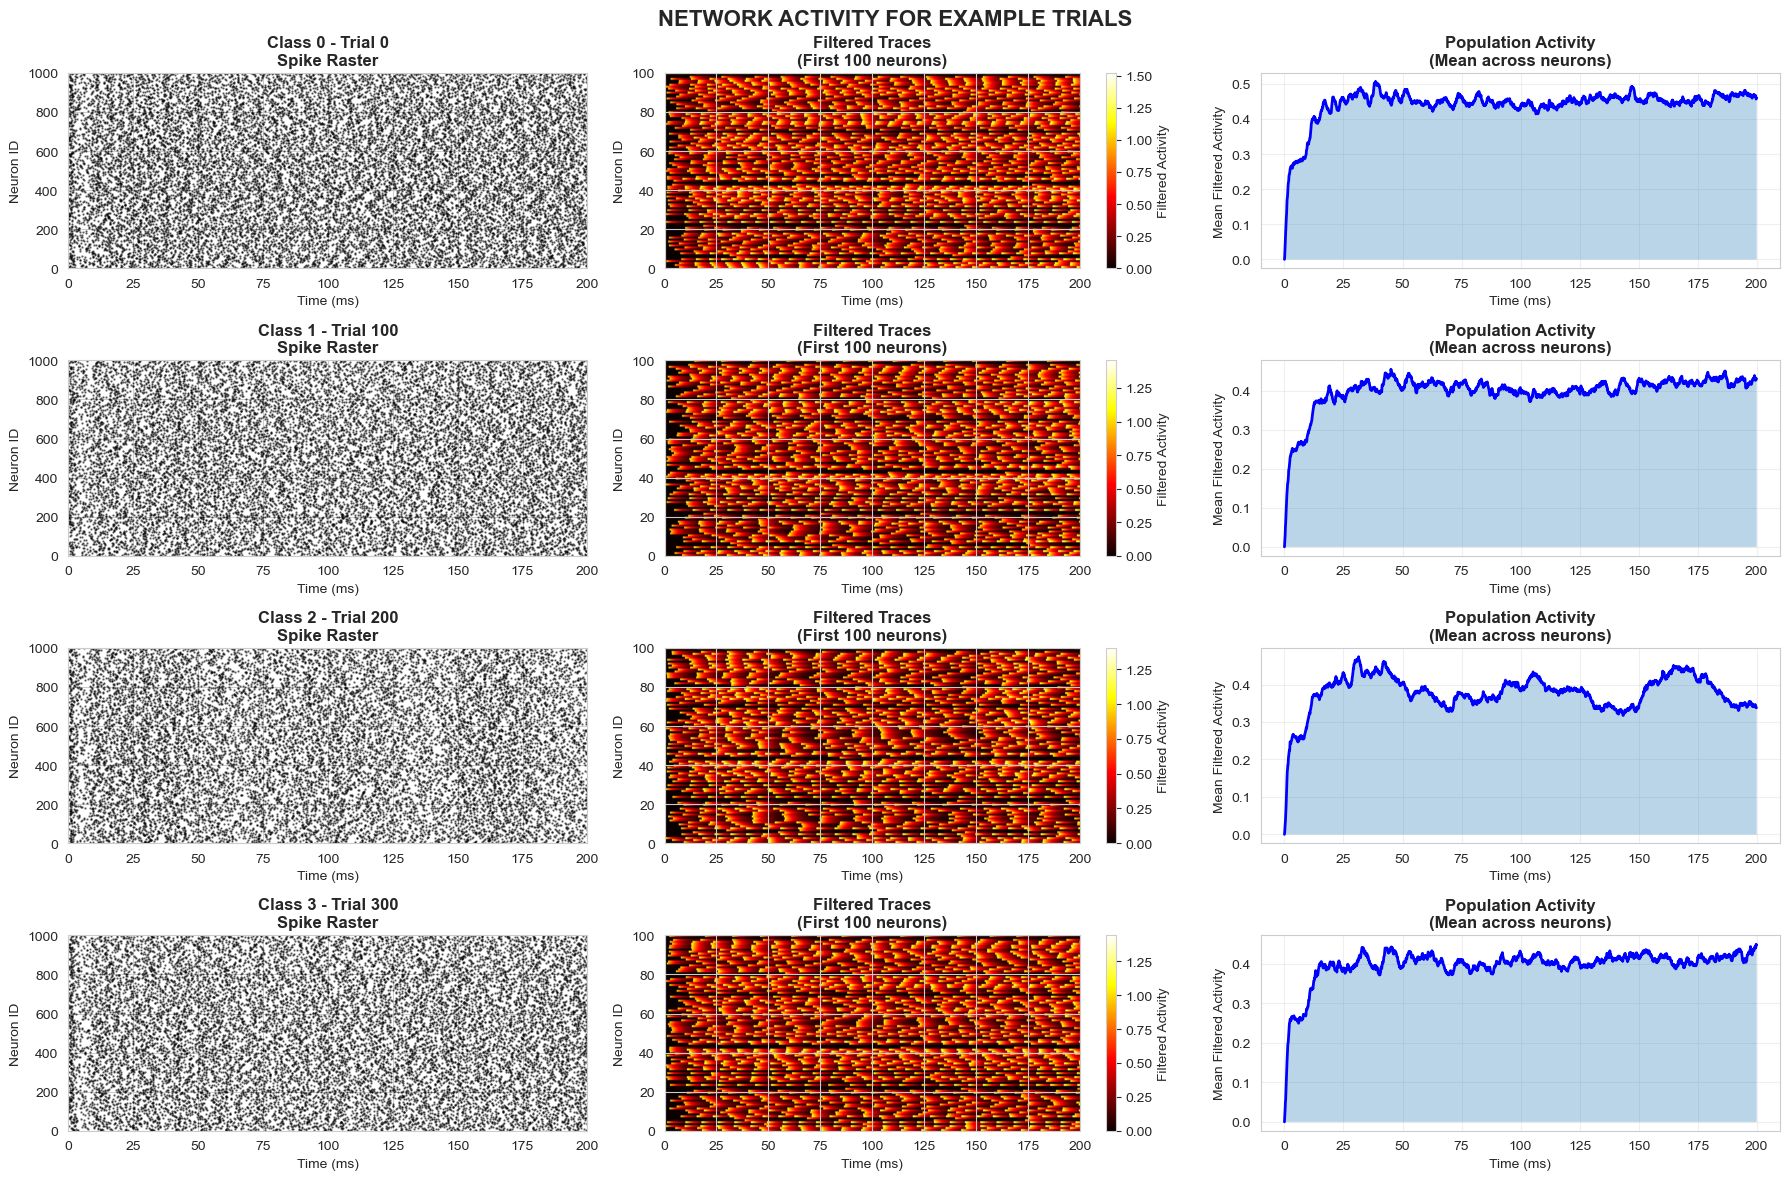

In [4]:
# ============================================================================
# PART 4: CONVERT TO TRACES AND VISUALIZE NETWORK ACTIVITY
# ============================================================================

print("=" * 80)
print("CONVERTING SPIKES TO FILTERED TRACES")
print("=" * 80)

# Sort trials
trial_results_sorted = sorted(trial_results, key=lambda x: x['global_trial_idx'])

# Convert to traces
n_timesteps = int(STIMULUS_DURATION / DT)
traces_list = []
ground_truth_list = []
pattern_ids_list = []

print(f"\nConverting {len(trial_results_sorted)} trials to traces...")
for trial_result in trial_results_sorted:
    # Convert spikes to matrix
    spike_matrix = spikes_to_matrix(
        trial_result['spike_times'],
        n_timesteps,
        N_NEURONS,
        DT
    )
    
    # Apply exponential filtering
    traces = apply_exponential_filter(spike_matrix, TAU_SYN, DT)
    traces_list.append(traces)
    
    # Get ground truth
    pattern_id = trial_result['pattern_id']
    ground_truth = output_patterns[pattern_id]
    ground_truth_list.append(ground_truth)
    pattern_ids_list.append(pattern_id)

traces_all = np.array(traces_list)
ground_truth_all = np.array(ground_truth_list)
pattern_ids = np.array(pattern_ids_list)

print(f"✓ Conversion complete!")
print(f"  Traces shape: {traces_all.shape}")
print(f"  Ground truth shape: {ground_truth_all.shape}")

# ============================================================================
# VISUALIZE NETWORK ACTIVITY
# ============================================================================

# Select a few example trials (one per class)
example_trials = [0, N_TRIALS_PER_PATTERN, 2*N_TRIALS_PER_PATTERN, 3*N_TRIALS_PER_PATTERN]

fig, axes = plt.subplots(N_INPUT_PATTERNS, 3, figsize=(18, 12))

for idx, trial_idx in enumerate(example_trials):
    pattern_id = pattern_ids[trial_idx]
    
    # Column 1: Spike raster
    ax = axes[idx, 0]
    spikes = trial_results_sorted[trial_idx]['spike_times']
    spike_times = [s[0] for s in spikes]
    spike_neurons = [s[1] for s in spikes]
    
    ax.scatter(spike_times, spike_neurons, s=0.5, c='black', alpha=0.5)
    ax.set_title(f'Class {pattern_id} - Trial {trial_idx}\nSpike Raster', fontweight='bold')
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Neuron ID')
    ax.set_xlim([0, STIMULUS_DURATION])
    ax.set_ylim([0, N_NEURONS])
    
    # Column 2: Filtered traces (heatmap of first 100 neurons)
    ax = axes[idx, 1]
    traces_sample = traces_all[trial_idx, :, :100].T
    im = ax.imshow(traces_sample, aspect='auto', cmap='hot', 
                   extent=[0, STIMULUS_DURATION, 0, 100])
    ax.set_title(f'Filtered Traces\n(First 100 neurons)', fontweight='bold')
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Neuron ID')
    plt.colorbar(im, ax=ax, label='Filtered Activity')
    
    # Column 3: Population activity over time
    ax = axes[idx, 2]
    population_activity = traces_all[trial_idx].mean(axis=1)
    time_ms = np.arange(n_timesteps) * DT
    ax.plot(time_ms, population_activity, 'b-', linewidth=2)
    ax.fill_between(time_ms, 0, population_activity, alpha=0.3)
    ax.set_title(f'Population Activity\n(Mean across neurons)', fontweight='bold')
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Mean Filtered Activity')
    ax.grid(True, alpha=0.3)

plt.suptitle('NETWORK ACTIVITY FOR EXAMPLE TRIALS', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [5]:
# ============================================================================
# PART 5: CROSS-VALIDATION TRAINING
# ============================================================================

from sklearn.model_selection import StratifiedKFold

print("=" * 80)
print("CROSS-VALIDATION TRAINING")
print("=" * 80)

N_FOLDS = 10
print(f"\nPerforming {N_FOLDS}-fold cross-validation...")
print(f"Training readout weights with ridge regression (λ={LAMBDA_REG})")

# Setup CV
skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=42)
fold_splits = list(skf.split(traces_all, pattern_ids))

# Store results
fold_results = []
all_weights = []
decision_window_steps = int(DECISION_WINDOW / DT)

for cv_iter, (train_idx, test_idx) in enumerate(fold_splits):
    print(f"  Fold {cv_iter + 1}/{N_FOLDS}...", end=' ')
    
    # Split data
    X_train = traces_all[train_idx]
    X_test = traces_all[test_idx]
    y_train = ground_truth_all[train_idx]
    y_test = ground_truth_all[test_idx]
    
    # Train readout
    W_readout = train_task_readout(X_train, y_train, LAMBDA_REG)
    all_weights.append(W_readout.copy())
    
    # Predict
    y_pred_train = predict_task_readout(X_train, W_readout)
    y_pred_test = predict_task_readout(X_test, W_readout)
    
    # Evaluate
    train_metrics = evaluate_categorical_task(y_pred_train, y_train, decision_window_steps)
    test_metrics = evaluate_categorical_task(y_pred_test, y_test, decision_window_steps)
    
    fold_results.append({
        'fold': cv_iter,
        'train_accuracy': train_metrics['accuracy'],
        'test_accuracy': test_metrics['accuracy'],
        'confusion_matrix': test_metrics['confusion_matrix'],
        'per_class_accuracy': test_metrics['per_class_accuracy'],
        'train_idx': train_idx,
        'test_idx': test_idx,
        'y_pred_train': y_pred_train,
        'y_pred_test': y_pred_test,
        'y_train': y_train,
        'y_test': y_test
    })
    
    print(f"Train: {train_metrics['accuracy']:.3f}, Test: {test_metrics['accuracy']:.3f}")

print("\n✓ Cross-validation complete!")

# Aggregate results
train_acc = [f['train_accuracy'] for f in fold_results]
test_acc = [f['test_accuracy'] for f in fold_results]

print(f"\n{'=' * 60}")
print("CROSS-VALIDATION RESULTS")
print(f"{'=' * 60}")
print(f"Train Accuracy: {np.mean(train_acc):.3f} ± {np.std(train_acc):.3f}")
print(f"Test Accuracy:  {np.mean(test_acc):.3f} ± {np.std(test_acc):.3f}")
print(f"{'=' * 60}")

CROSS-VALIDATION TRAINING

Performing 10-fold cross-validation...
Training readout weights with ridge regression (λ=0.001)
  Fold 1/10... Train: 0.883, Test: 0.800
  Fold 2/10... Train: 0.872, Test: 0.850
  Fold 3/10... Train: 0.872, Test: 0.875
  Fold 4/10... Train: 0.864, Test: 0.825
  Fold 5/10... Train: 0.869, Test: 0.850
  Fold 6/10... Train: 0.864, Test: 0.800
  Fold 7/10... Train: 0.864, Test: 0.750
  Fold 8/10... Train: 0.867, Test: 0.800
  Fold 9/10... Train: 0.861, Test: 0.875
  Fold 10/10... Train: 0.864, Test: 0.875

✓ Cross-validation complete!

CROSS-VALIDATION RESULTS
Train Accuracy: 0.868 ± 0.006
Test Accuracy:  0.830 ± 0.040


/var/folders/vq/wqh08z6d6wbcm3z2r206cfn00000gn/T/ipykernel_3819/946768401.py:130: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


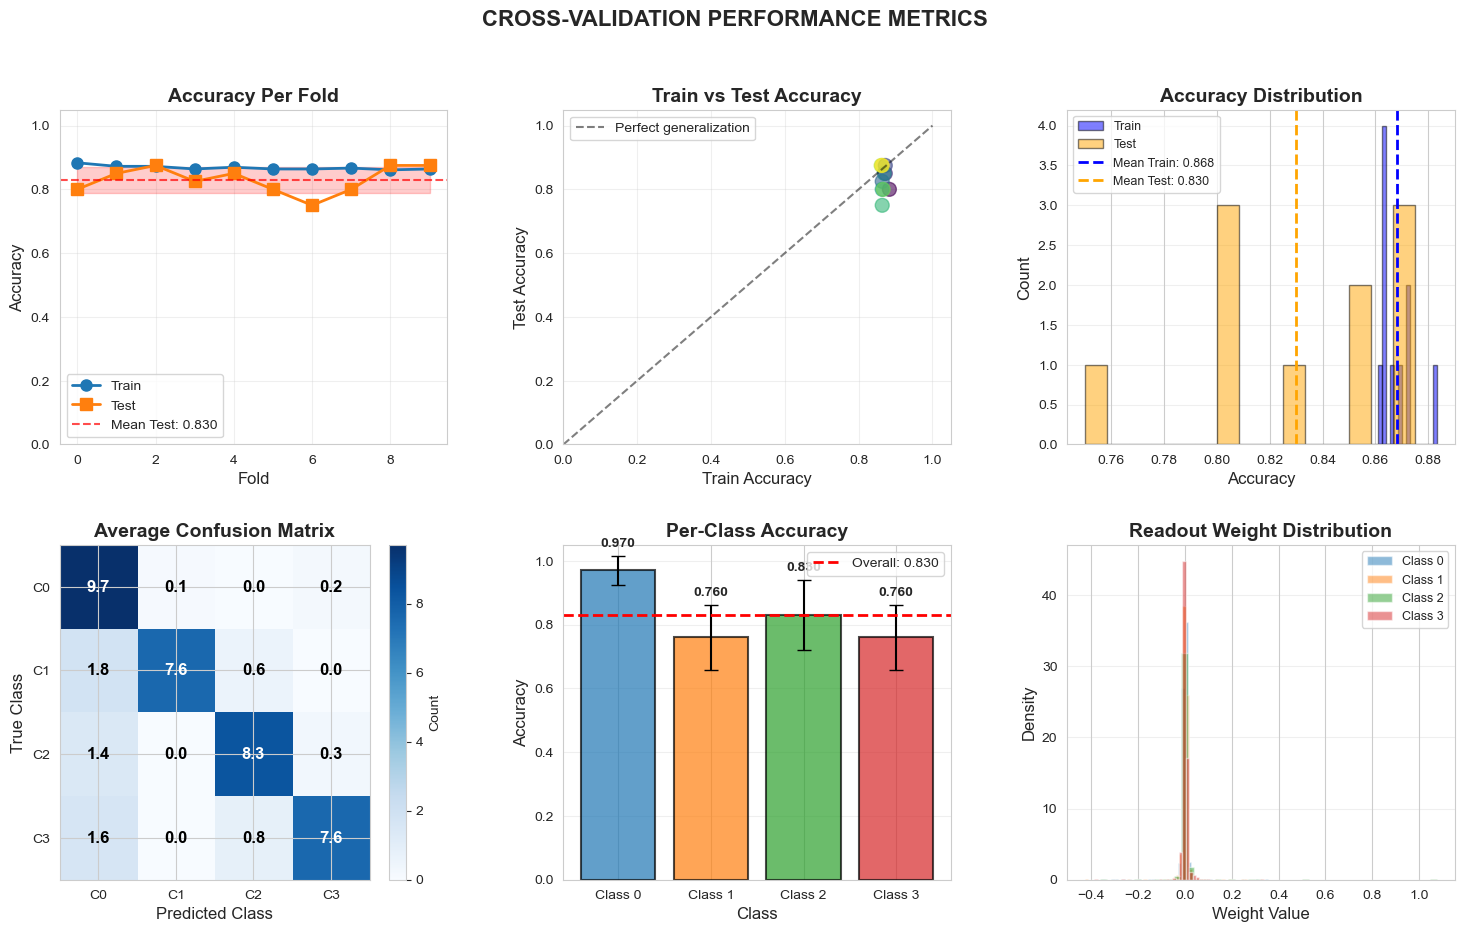

In [6]:
# ============================================================================
# PART 6: VISUALIZE PERFORMANCE METRICS
# ============================================================================

fig = plt.figure(figsize=(18, 10))
gs = GridSpec(2, 3, figure=fig, hspace=0.3, wspace=0.3)

# ============================================================================
# Plot 1: Accuracy per fold
# ============================================================================
ax1 = fig.add_subplot(gs[0, 0])
folds = np.arange(N_FOLDS)
ax1.plot(folds, train_acc, 'o-', label='Train', linewidth=2, markersize=8)
ax1.plot(folds, test_acc, 's-', label='Test', linewidth=2, markersize=8)
ax1.axhline(np.mean(test_acc), color='r', linestyle='--', alpha=0.7, 
            label=f'Mean Test: {np.mean(test_acc):.3f}')
ax1.fill_between(folds, 
                  np.mean(test_acc) - np.std(test_acc),
                  np.mean(test_acc) + np.std(test_acc),
                  alpha=0.2, color='red')
ax1.set_xlabel('Fold', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.set_title('Accuracy Per Fold', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.set_ylim([0, 1.05])

# ============================================================================
# Plot 2: Train vs Test accuracy scatter
# ============================================================================
ax2 = fig.add_subplot(gs[0, 1])
ax2.scatter(train_acc, test_acc, s=100, alpha=0.6, c=folds, cmap='viridis')
ax2.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Perfect generalization')
ax2.set_xlabel('Train Accuracy', fontsize=12)
ax2.set_ylabel('Test Accuracy', fontsize=12)
ax2.set_title('Train vs Test Accuracy', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)
ax2.set_xlim([0, 1.05])
ax2.set_ylim([0, 1.05])

# ============================================================================
# Plot 3: Accuracy distribution
# ============================================================================
ax3 = fig.add_subplot(gs[0, 2])
ax3.hist(train_acc, bins=15, alpha=0.5, label='Train', color='blue', edgecolor='black')
ax3.hist(test_acc, bins=15, alpha=0.5, label='Test', color='orange', edgecolor='black')
ax3.axvline(np.mean(train_acc), color='blue', linestyle='--', linewidth=2, label=f'Mean Train: {np.mean(train_acc):.3f}')
ax3.axvline(np.mean(test_acc), color='orange', linestyle='--', linewidth=2, label=f'Mean Test: {np.mean(test_acc):.3f}')
ax3.set_xlabel('Accuracy', fontsize=12)
ax3.set_ylabel('Count', fontsize=12)
ax3.set_title('Accuracy Distribution', fontsize=14, fontweight='bold')
ax3.legend(fontsize=9)
ax3.grid(True, alpha=0.3, axis='y')

# ============================================================================
# Plot 4: Average confusion matrix
# ============================================================================
ax4 = fig.add_subplot(gs[1, 0])
avg_confusion = np.mean([f['confusion_matrix'] for f in fold_results], axis=0)
im = ax4.imshow(avg_confusion, cmap='Blues', aspect='auto')

# Add text annotations
for i in range(N_INPUT_PATTERNS):
    for j in range(N_INPUT_PATTERNS):
        text = ax4.text(j, i, f'{avg_confusion[i, j]:.1f}',
                       ha="center", va="center", color="black" if avg_confusion[i, j] < avg_confusion.max()/2 else "white",
                       fontsize=12, fontweight='bold')

ax4.set_xlabel('Predicted Class', fontsize=12)
ax4.set_ylabel('True Class', fontsize=12)
ax4.set_title('Average Confusion Matrix', fontsize=14, fontweight='bold')
ax4.set_xticks(np.arange(N_INPUT_PATTERNS))
ax4.set_yticks(np.arange(N_INPUT_PATTERNS))
ax4.set_xticklabels([f'C{i}' for i in range(N_INPUT_PATTERNS)])
ax4.set_yticklabels([f'C{i}' for i in range(N_INPUT_PATTERNS)])
plt.colorbar(im, ax=ax4, label='Count')

# ============================================================================
# Plot 5: Per-class accuracy
# ============================================================================
ax5 = fig.add_subplot(gs[1, 1])
per_class_acc = np.mean([f['per_class_accuracy'] for f in fold_results], axis=0)
per_class_std = np.std([f['per_class_accuracy'] for f in fold_results], axis=0)

classes = [f'Class {i}' for i in range(N_INPUT_PATTERNS)]
x_pos = np.arange(N_INPUT_PATTERNS)

bars = ax5.bar(x_pos, per_class_acc, yerr=per_class_std, capsize=5,
               alpha=0.7, color=['C0', 'C1', 'C2', 'C3'][:N_INPUT_PATTERNS],
               edgecolor='black', linewidth=1.5)

ax5.axhline(np.mean(per_class_acc), color='r', linestyle='--', 
            label=f'Overall: {np.mean(per_class_acc):.3f}', linewidth=2)
ax5.set_xlabel('Class', fontsize=12)
ax5.set_ylabel('Accuracy', fontsize=12)
ax5.set_title('Per-Class Accuracy', fontsize=14, fontweight='bold')
ax5.set_xticks(x_pos)
ax5.set_xticklabels(classes)
ax5.legend(fontsize=10)
ax5.grid(True, alpha=0.3, axis='y')
ax5.set_ylim([0, 1.05])

# Add value labels on bars
for i, (bar, acc) in enumerate(zip(bars, per_class_acc)):
    height = bar.get_height()
    ax5.text(bar.get_x() + bar.get_width()/2., height + per_class_std[i] + 0.02,
             f'{acc:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# ============================================================================
# Plot 6: Readout weight analysis
# ============================================================================
ax6 = fig.add_subplot(gs[1, 2])

# Average readout weights across folds
avg_weights = np.mean([w for w in all_weights], axis=0)  # Shape: (N_NEURONS, N_INPUT_PATTERNS)

# Show weight distribution per output class
for class_idx in range(N_INPUT_PATTERNS):
    ax6.hist(avg_weights[:, class_idx], bins=50, alpha=0.5, 
             label=f'Class {class_idx}', density=True)

ax6.set_xlabel('Weight Value', fontsize=12)
ax6.set_ylabel('Density', fontsize=12)
ax6.set_title('Readout Weight Distribution', fontsize=14, fontweight='bold')
ax6.legend(fontsize=9)
ax6.grid(True, alpha=0.3, axis='y')

plt.suptitle('CROSS-VALIDATION PERFORMANCE METRICS', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

/var/folders/vq/wqh08z6d6wbcm3z2r206cfn00000gn/T/ipykernel_3819/3715735776.py:108: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


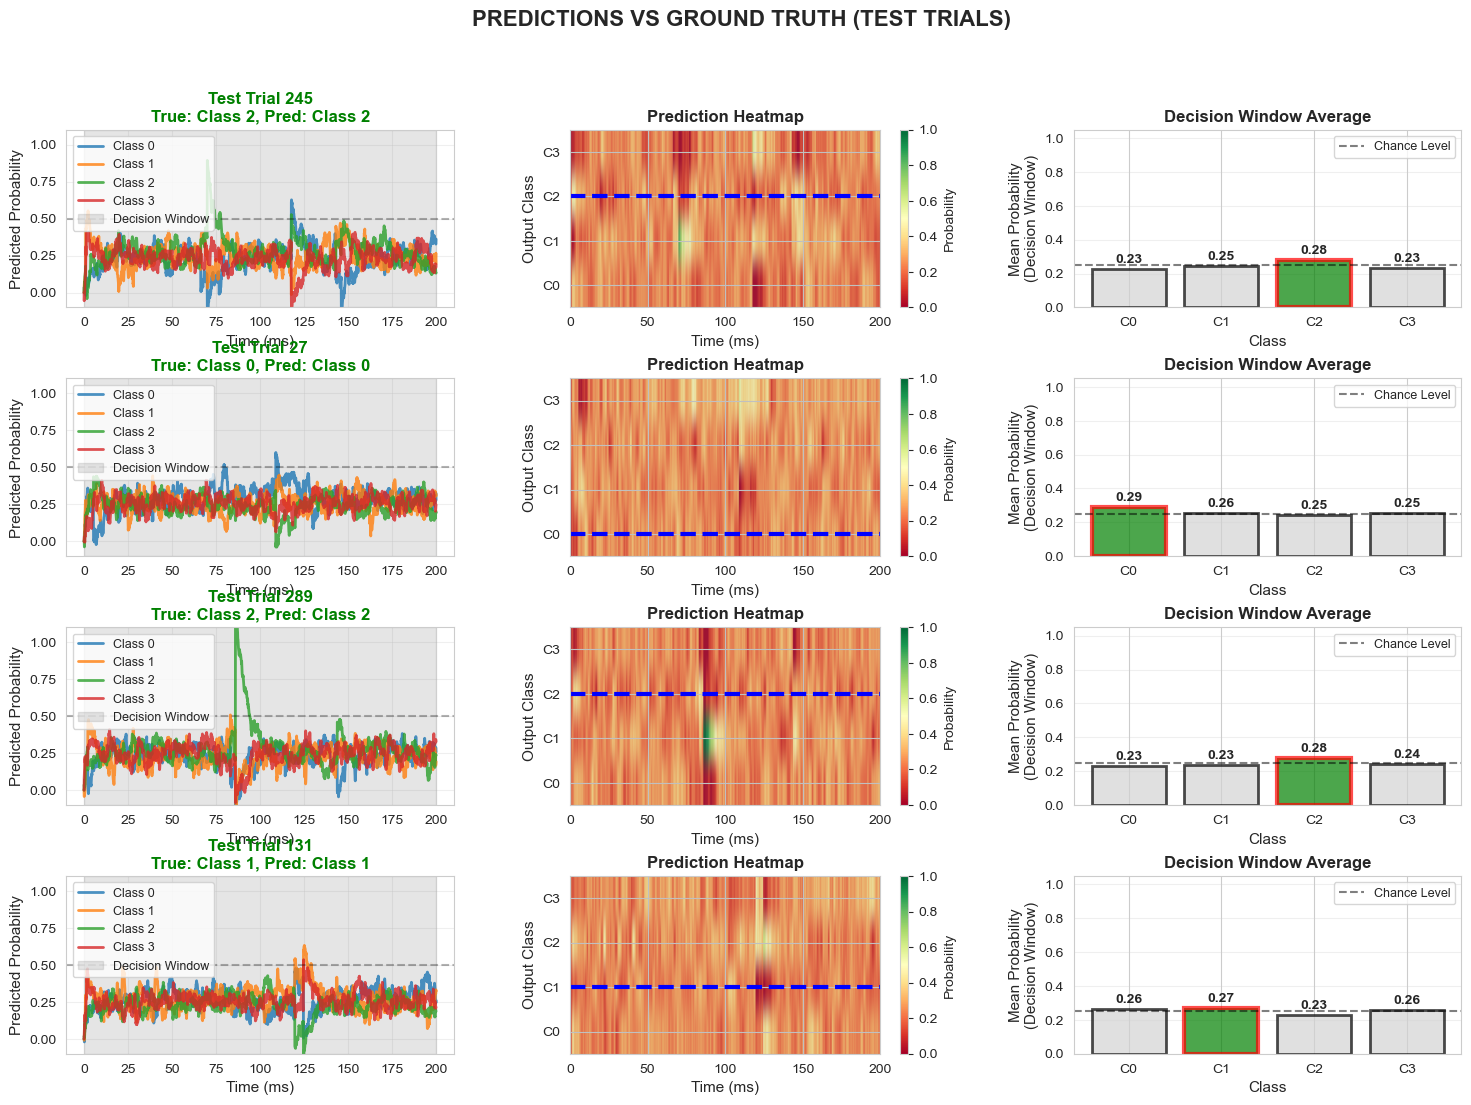


TEST TRIAL ANALYSIS
Test trials analyzed: 40
Correct predictions: 35/40 (87.5%)


In [7]:
# ============================================================================
# PART 7: VISUALIZE PREDICTIONS VS GROUND TRUTH (TRAIN AND TEST)
# ============================================================================

# Use the last fold for detailed visualization
last_fold = fold_results[-1]
y_pred_train = last_fold['y_pred_train']
y_pred_test = last_fold['y_pred_test']
y_train = last_fold['y_train']
y_test = last_fold['y_test']
train_idx = last_fold['train_idx']
test_idx = last_fold['test_idx']

# Select example trials
n_examples = min(4, len(test_idx))
example_test_indices = np.random.choice(len(test_idx), n_examples, replace=False)

fig = plt.figure(figsize=(18, 12))
gs = GridSpec(n_examples, 3, figure=fig, hspace=0.4, wspace=0.3)

time_ms = np.arange(n_timesteps) * DT
decision_start_ms = STIMULUS_DURATION - DECISION_WINDOW

for row, example_idx in enumerate(example_test_indices):
    global_trial_idx = test_idx[example_idx]
    true_class = pattern_ids[global_trial_idx]
    
    # Get predictions and ground truth
    pred = y_pred_test[example_idx]  # Shape: (n_timesteps, n_classes)
    truth = y_test[example_idx]  # Shape: (n_timesteps, n_classes)
    
    # Decision window average
    decision_pred = pred[-int(DECISION_WINDOW/DT):].mean(axis=0)
    predicted_class = np.argmax(decision_pred)
    
    # ========================================================================
    # Column 1: Raw predictions over time
    # ========================================================================
    ax = fig.add_subplot(gs[row, 0])
    for class_idx in range(N_INPUT_PATTERNS):
        ax.plot(time_ms, pred[:, class_idx], linewidth=2, 
                label=f'Class {class_idx}', alpha=0.8)
    
    ax.axvspan(decision_start_ms, STIMULUS_DURATION, alpha=0.2, color='gray', 
               label='Decision Window')
    ax.axhline(0.5, color='k', linestyle='--', alpha=0.3)
    
    ax.set_xlabel('Time (ms)', fontsize=11)
    ax.set_ylabel('Predicted Probability', fontsize=11)
    ax.set_title(f'Test Trial {global_trial_idx}\nTrue: Class {true_class}, Pred: Class {predicted_class}',
                 fontsize=12, fontweight='bold',
                 color='green' if true_class == predicted_class else 'red')
    ax.legend(fontsize=9, loc='upper left')
    ax.grid(True, alpha=0.3)
    ax.set_ylim([-0.1, 1.1])
    
    # ========================================================================
    # Column 2: Heatmap of predictions
    # ========================================================================
    ax = fig.add_subplot(gs[row, 1])
    im = ax.imshow(pred.T, aspect='auto', cmap='RdYlGn', vmin=0, vmax=1,
                   extent=[0, STIMULUS_DURATION, 0, N_INPUT_PATTERNS])
    
    # Mark true class
    ax.axhline(true_class + 0.5, color='blue', linewidth=3, linestyle='--',
               label='True Class')
    ax.axvspan(decision_start_ms, STIMULUS_DURATION, alpha=0.15, color='gray')
    
    ax.set_xlabel('Time (ms)', fontsize=11)
    ax.set_ylabel('Output Class', fontsize=11)
    ax.set_title('Prediction Heatmap', fontsize=12, fontweight='bold')
    ax.set_yticks(np.arange(N_INPUT_PATTERNS) + 0.5)
    ax.set_yticklabels([f'C{i}' for i in range(N_INPUT_PATTERNS)])
    plt.colorbar(im, ax=ax, label='Probability')
    
    # ========================================================================
    # Column 3: Decision window analysis
    # ========================================================================
    ax = fig.add_subplot(gs[row, 2])
    
    # Bar plot of decision window averages
    x_pos = np.arange(N_INPUT_PATTERNS)
    colors = ['green' if i == true_class else 'lightgray' for i in range(N_INPUT_PATTERNS)]
    bars = ax.bar(x_pos, decision_pred, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
    
    # Highlight predicted class
    bars[predicted_class].set_edgecolor('red')
    bars[predicted_class].set_linewidth(3)
    
    ax.axhline(1.0 / N_INPUT_PATTERNS, color='k', linestyle='--', alpha=0.5, 
               label='Chance Level')
    ax.set_xlabel('Class', fontsize=11)
    ax.set_ylabel('Mean Probability\n(Decision Window)', fontsize=11)
    ax.set_title('Decision Window Average', fontsize=12, fontweight='bold')
    ax.set_xticks(x_pos)
    ax.set_xticklabels([f'C{i}' for i in range(N_INPUT_PATTERNS)])
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_ylim([0, 1.05])
    
    # Add value labels
    for i, (bar, val) in enumerate(zip(bars, decision_pred)):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{val:.2f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.suptitle('PREDICTIONS VS GROUND TRUTH (TEST TRIALS)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# ============================================================================
# Summary statistics
# ============================================================================
print("\n" + "=" * 60)
print("TEST TRIAL ANALYSIS")
print("=" * 60)

test_predictions = y_pred_test[:, -int(DECISION_WINDOW/DT):].mean(axis=1).argmax(axis=1)
test_truth = pattern_ids[test_idx]
test_correct = (test_predictions == test_truth).sum()

print(f"Test trials analyzed: {len(test_idx)}")
print(f"Correct predictions: {test_correct}/{len(test_idx)} ({test_correct/len(test_idx)*100:.1f}%)")
print("=" * 60)

In [8]:
# ============================================================================
# PART 8: PERFORMANCE SUMMARY AND ANALYSIS
# ============================================================================

print("=" * 80)
print("FINAL PERFORMANCE SUMMARY")
print("=" * 80)

# ============================================================================
# Overall metrics
# ============================================================================
print("\n📊 OVERALL METRICS")
print("-" * 60)
print(f"Training Accuracy:   {np.mean(train_acc):.4f} ± {np.std(train_acc):.4f}")
print(f"Test Accuracy:       {np.mean(test_acc):.4f} ± {np.std(test_acc):.4f}")
print(f"Best Fold (Test):    {np.max(test_acc):.4f} (Fold {np.argmax(test_acc)})")
print(f"Worst Fold (Test):   {np.min(test_acc):.4f} (Fold {np.argmin(test_acc)})")
print(f"Chance Level:        {1.0/N_INPUT_PATTERNS:.4f}")

# ============================================================================
# Per-class performance
# ============================================================================
print("\n🎯 PER-CLASS PERFORMANCE")
print("-" * 60)
per_class_acc_mean = np.mean([f['per_class_accuracy'] for f in fold_results], axis=0)
per_class_acc_std = np.std([f['per_class_accuracy'] for f in fold_results], axis=0)

for class_idx in range(N_INPUT_PATTERNS):
    print(f"Class {class_idx}: {per_class_acc_mean[class_idx]:.4f} ± {per_class_acc_std[class_idx]:.4f}")

# ============================================================================
# Confusion analysis
# ============================================================================
print("\n❌ CONFUSION ANALYSIS")
print("-" * 60)
avg_confusion = np.mean([f['confusion_matrix'] for f in fold_results], axis=0)

print("Average Confusion Matrix:")
print("         Predicted:")
print("        ", "  ".join([f"C{i}" for i in range(N_INPUT_PATTERNS)]))
for i in range(N_INPUT_PATTERNS):
    row_str = f"True C{i}: " + "  ".join([f"{avg_confusion[i,j]:4.1f}" for j in range(N_INPUT_PATTERNS)])
    print(row_str)

# Most confused pairs
confusion_pairs = []
for i in range(N_INPUT_PATTERNS):
    for j in range(N_INPUT_PATTERNS):
        if i != j:
            confusion_pairs.append((i, j, avg_confusion[i, j]))

confusion_pairs.sort(key=lambda x: x[2], reverse=True)
print("\nMost Confused Class Pairs:")
for i, j, count in confusion_pairs[:3]:
    print(f"  Class {i} → Class {j}: {count:.1f} misclassifications")

# ============================================================================
# Network analysis
# ============================================================================
print("\n🧠 NETWORK ANALYSIS")
print("-" * 60)
print(f"Number of neurons:     {N_NEURONS}")
print(f"Heterogeneity:")
print(f"  v_th_std:            {V_TH_STD}")
print(f"  g_std:               {G_STD}")
print(f"Input dimensionality:")
print(f"  Intrinsic (HD):      {INPUT_HD_DIM}")
print(f"  Embedding:           {INPUT_EMBED_DIM}")
print(f"Readout parameters:")
print(f"  Regularization (λ):  {LAMBDA_REG}")
print(f"  Synaptic tau:        {TAU_SYN} ms")
print(f"  Decision window:     {DECISION_WINDOW} ms")

# ============================================================================
# Statistical significance
# ============================================================================
print("\n📈 STATISTICAL ANALYSIS")
print("-" * 60)

from scipy import stats

# Test if accuracy is significantly above chance
chance_level = 1.0 / N_INPUT_PATTERNS
t_stat, p_value = stats.ttest_1samp(test_acc, chance_level)

print(f"One-sample t-test vs chance level ({chance_level:.4f}):")
print(f"  t-statistic:  {t_stat:.4f}")
print(f"  p-value:      {p_value:.2e}")
if p_value < 0.001:
    print(f"  Result:       *** Highly significant (p < 0.001)")
elif p_value < 0.01:
    print(f"  Result:       ** Significant (p < 0.01)")
elif p_value < 0.05:
    print(f"  Result:       * Significant (p < 0.05)")
else:
    print(f"  Result:       Not significant (p >= 0.05)")

# Effect size (Cohen's d)
cohens_d = (np.mean(test_acc) - chance_level) / np.std(test_acc)
print(f"  Cohen's d:    {cohens_d:.4f}", end="")
if cohens_d > 1.2:
    print(" (very large effect)")
elif cohens_d > 0.8:
    print(" (large effect)")
elif cohens_d > 0.5:
    print(" (medium effect)")
else:
    print(" (small effect)")

# ============================================================================
# Generalization analysis
# ============================================================================
print("\n🔄 GENERALIZATION ANALYSIS")
print("-" * 60)

generalization_gap = np.array(train_acc) - np.array(test_acc)
print(f"Mean generalization gap: {np.mean(generalization_gap):.4f} ± {np.std(generalization_gap):.4f}")
print(f"Min gap:                 {np.min(generalization_gap):.4f}")
print(f"Max gap:                 {np.max(generalization_gap):.4f}")

if np.mean(generalization_gap) < 0.05:
    print("Interpretation: Excellent generalization (low overfitting)")
elif np.mean(generalization_gap) < 0.1:
    print("Interpretation: Good generalization (minimal overfitting)")
elif np.mean(generalization_gap) < 0.2:
    print("Interpretation: Moderate overfitting")
else:
    print("Interpretation: High overfitting - consider more regularization")

print("\n" + "=" * 80)
print("✅ ANALYSIS COMPLETE!")
print("=" * 80)

FINAL PERFORMANCE SUMMARY

📊 OVERALL METRICS
------------------------------------------------------------
Training Accuracy:   0.8681 ± 0.0062
Test Accuracy:       0.8300 ± 0.0400
Best Fold (Test):    0.8750 (Fold 2)
Worst Fold (Test):   0.7500 (Fold 6)
Chance Level:        0.2500

🎯 PER-CLASS PERFORMANCE
------------------------------------------------------------
Class 0: 0.9700 ± 0.0458
Class 1: 0.7600 ± 0.1020
Class 2: 0.8300 ± 0.1100
Class 3: 0.7600 ± 0.1020

❌ CONFUSION ANALYSIS
------------------------------------------------------------
Average Confusion Matrix:
         Predicted:
         C0  C1  C2  C3
True C0:  9.7   0.1   0.0   0.2
True C1:  1.8   7.6   0.6   0.0
True C2:  1.4   0.0   8.3   0.3
True C3:  1.6   0.0   0.8   7.6

Most Confused Class Pairs:
  Class 1 → Class 0: 1.8 misclassifications
  Class 3 → Class 0: 1.6 misclassifications
  Class 2 → Class 0: 1.4 misclassifications

🧠 NETWORK ANALYSIS
------------------------------------------------------------
Number of 